## 1. 포지션 예측

오피지지 이스포츠 데이터분석 전문가 양성과정 마지막 프로젝트이다.

주제는 롤 매치 데이터를 이용해 각 챔피언(유저)별 포지션을 예측하는 것으로 설정했다.

라이엇 API를 사용해 매치 데이터를 불러오면 lane이라는 포지션 변수가 있지만 매우 부정확하다.

하지만 OP.GG를 비롯한 전적 검색 사이트에서 검색시 대부분 포지션이 잘 분류되어 나타난다.

검색 결과에서 나오는 포지션 역시 예측한 것이므로 이를 나름의 방식으로 직접 구현해보도록 한다.

**[패키지 설정]**

In [1]:
import numpy as np
import pandas as pd
import requests
from pandas.api.types import CategoricalDtype

import missingno as msno

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

- 딥러닝 라이브러리로는 tensorflow를 사용하였고 참고로 버전은 2.0.0이다.

**[필요 함수]**

In [3]:
# train, test 분포 확인
def visualization(df1, df2, col):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))

    # histplot
    sns.histplot(eval(df1)[col], ax=axs[0,0])
    sns.histplot(eval(df2)[col], ax=axs[0,1])

    # title
    axs[0,0].set(title=f"{df1} {col} 분포")
    axs[0,1].set(title=f"{df2} {col} 분포")

    # x축 범위 통일
    l1 = axs[0,0].get_xlim()
    l2 = axs[0,1].get_xlim()

    min_l = min(l1[0],l2[0])
    max_l = max(l1[1],l2[1])

    axs[0,0].set_xlim([min_l, max_l])
    axs[0,1].set_xlim([min_l, max_l])

    # box plot
    sns.boxplot(data = eval(df1), x = col , y = "position", palette = "pastel", ax=axs[1,0])
    sns.boxplot(data = eval(df2), x = col , y = "position", palette = "pastel", ax=axs[1,1])

    return plt.show()

In [4]:
# 챔피언 정보, 스펠, 아이템 정보 불러오기
def load_riot_info(lan="ko_KR"):
    champ_ver = requests.get('https://ddragon.leagueoflegends.com/realms/na.json').json()['n']['champion']

    championJsonURL = f'http://ddragon.leagueoflegends.com/cdn/{champ_ver}/data/{lan}/champion.json'
    spellJsonURL = f'http://ddragon.leagueoflegends.com/cdn/{champ_ver}/data/{lan}/summoner.json'
    itemURL = f'http://ddragon.leagueoflegends.com/cdn/{champ_ver}/data/{lan}/item.json'

    # 데이터 프레임으로 만들기
    request1 = requests.get(championJsonURL)
    request2 = requests.get(spellJsonURL)
    request3 = requests.get(itemURL)

    champion_data = request1.json()
    champion_df = pd.DataFrame(champion_data['data']).T[["key","name"]]

    spell_data = request2.json()
    spell_df = pd.DataFrame(spell_data['data']).T[["key","name"]].reset_index(drop=True)

    item_data = request3.json()
    item_df = pd.DataFrame(item_data['data']).T[["name"]].reset_index()
    item_df.rename(columns={"index":"key"}, inplace=True)

    # key type 변경
    champion_df["key"] = champion_df["key"].astype(int)
    spell_df["key"] = spell_df["key"].astype(int)
    item_df["key"] = item_df["key"].astype(int)
    
    return champion_df, spell_df, item_df

In [5]:
# id값들 이름 붙이기 (임시)
def merge_name(df):
    # 챔피언 붙이기
    df = pd.merge(df, champion_df, left_on="championId", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"champion"}, inplace=True)

    # 스펠 붙이기
    df = pd.merge(df, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
    df = pd.merge(df, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name_x":"spell01", "name_y":"spell02"}, inplace=True)

    # 아이템 붙이기
    df = pd.merge(df, item_df, left_on="item0", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item00"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item1", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item01"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item2", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item02"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item3", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item03"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item4", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item04"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item5", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item05"}, inplace=True)
    df = pd.merge(df, item_df, left_on="item6", right_on="key", how="left").drop("key", axis=1)
    df.rename(columns={"name":"item06"}, inplace=True)
    
    return df

- 작업을 하면서 반복 사용했던 코드나 너무 긴 코드들은 따로 함수로 생성해두었다.

### 1.1 데이터 불러오기

주제를 설정하였으니 우선 데이터를 수집하지만 많은 양의 데이터를 직접 수집하기엔 시간적 문제 등이 있어 데이터는 제공받았다.

참고로 이전에 [롤 나의 게임 정보 불러오기](https://romg2.github.io/opgg/03_Day02_02_check_me/)에서 직접 매치 데이터를 수집했었다.

11.18 버전의 데이터 총 500만 건(50만 게임)이며 노트북 속도 문제로 300만 건만 사용하였다.

In [6]:
# index_col 오류 고려 drop 진행
# 데이터 게임 시간 추가
# df = pd.read_csv('ver1118_500.csv')
# df.drop('Unnamed: 0', inplace=True, axis=1)

# test_gameLength = pd.read_csv('gameLength.csv', index_col=0)
# test = pd.merge(df, test_gameLength, on="gameId")

# # 데이터 자르기 3백만 (gameId 기준 sort이므로 로우 순서로 잘랐음)
# temp = test.iloc[0:3000000]
# temp.to_csv("data.csv")

In [7]:
# 챔피언, 스펠, 아이템 정보 불러오기
champion_df, spell_df, item_df = load_riot_info(lan="ko_KR")

In [8]:
# index_col 오류 고려 drop 진행
data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

In [9]:
# 포지션 카테고리 타입으로 변경
cat_size_order = CategoricalDtype(['T', 'J', 'M', 'A', 'S'], ordered=True)
data['position'] = data['position'].astype(cat_size_order)

In [10]:
# train test 우선은 gameid 기준 자르기 위해 로우 순서로 분리
train = data.iloc[0:2000000]
test = data.iloc[2000000:]

In [11]:
# 데이터 크기 확인
train.shape, test.shape

((2000000, 60), (1000000, 60))

- 300만 건의 데이터를 train 200만, test 100만으로 분리하였다.


- 랜덤하게 섞지 않은 이유는 gameid가 10개씩(한판에 10명) 나타나기 때문이다.


- (물론 gameid 갯수를 보고 랜덤하게 나눠도 된다.)

In [12]:
# 데이터별 게임 수
train["gameId"].nunique(), test["gameId"].nunique()

(200000, 100000)

- gameid 중복을 제거하면 각 데이터 셋의 게임 수가 20만, 10만 건임을 알 수 있다.

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 60 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   gameId                           int64   
 1   createDate                       object  
 2   teamId                           int64   
 3   summonerId                       int64   
 4   participantId                    int64   
 5   championId                       int64   
 6   result                           object  
 7   spell1                           int64   
 8   spell2                           int64   
 9   item0                            int64   
 10  item1                            int64   
 11  item2                            int64   
 12  item3                            int64   
 13  item4                            int64   
 14  item5                            int64   
 15  item6                            int64   
 16  level                            int

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 2000000 to 2999999
Data columns (total 60 columns):
 #   Column                           Non-Null Count    Dtype   
---  ------                           --------------    -----   
 0   gameId                           1000000 non-null  int64   
 1   createDate                       1000000 non-null  object  
 2   teamId                           1000000 non-null  int64   
 3   summonerId                       1000000 non-null  int64   
 4   participantId                    1000000 non-null  int64   
 5   championId                       1000000 non-null  int64   
 6   result                           1000000 non-null  object  
 7   spell1                           1000000 non-null  int64   
 8   spell2                           1000000 non-null  int64   
 9   item0                            1000000 non-null  int64   
 10  item1                            1000000 non-null  int64   
 11  item2                          

- 많은 컬럼이 있는데 opScore등은 원래 라이엇 API에는 없는 데이터이다.


- OP.GG 자체 로직으로 생성한 컬럼은 내가 구할 수 없기 때문에 추후 모델에서 사용하지 않기로 한다.

### 1.2 결측 확인

In [15]:
missing_train = train.isnull().sum()
missing_train[missing_train > 0]

tierRank    38266
dtype: int64

In [16]:
missing_test = test.isnull().sum()
missing_test[missing_test > 0]

tierRank    17636
dtype: int64

In [17]:
# 티어 유형 확인
# train["tierRank"].str[:1].unique()
test["tierRank"].str[:1].unique()

array(['G', 'P', 'B', 'S', 'D', nan, 'I', 'M', 'R', 'C'], dtype=object)

In [18]:
train["tierRank"].fillna("U", inplace = True)
test["tierRank"].fillna("U", inplace = True)

- 결측 존재하는 tierRank U(Unranked)로 대체

In [19]:
print("train 결측 수:", train.isna().sum().sum())
print("test 결측 수:", test.isna().sum().sum())

train 결측 수: 0
test 결측 수: 0


In [20]:
# tier 변수 추가
train["tier"] = train["tierRank"].str[:1]
test["tier"] = test["tierRank"].str[:1]

### 1.3 지표 추가

In [21]:
temp = train["neutralMinionsKilled"] == train["neutralMinionsKilledEnemyJungle"] + train["neutralMinionsKilledTeamJungle"]
temp.sum()

977939

- 정글 처치 수 = 적 정글 처치 수 + 아군 정글 처치 수가 성립이 안되는 경우가 너무 많음 (test도 같음)


- 인게임에서 지표 확인시 적,아군 정글 처치 수는 다 0으로 떠서 정글 처치 수 만 사용

In [22]:
# KDA 추가하기
def cal_KDA(df):
    # perfect KDA는 death에 1을 추가
    if df["numDeaths"] == 0:
        adjust = 1
    else:
        adjust = 0
        
    KDA = (df["championsKilled"] + df["assists"]) / (df["numDeaths"] + adjust)
    
    return KDA
    
train["KDA"] = train.apply(lambda x: cal_KDA(x), axis=1)
test["KDA"] = test.apply(lambda x: cal_KDA(x), axis=1)

In [23]:
# 각종 지표 추가
for df in [train, test]:
    df['GPM'] = df['goldEarned'] / df['gameLength'] * 60
    df['DPM'] = df['totalDamageDealt'] / df['gameLength'] * 60
    df['DTPM'] = df['totalDamageTaken'] / df['gameLength'] * 60
    df['CSPM'] = df['minionsKilled'] / df['gameLength'] * 60
    df['WKPM'] = df['wardKilled'] / df['gameLength'] * 60
    df['WPPM'] = df['wardPlaced'] / df['gameLength'] * 60
    df['JCSPM'] = df['neutralMinionsKilled'] / df['gameLength'] * 60
    df['WBPM'] = df['visionWardsBoughtInGame'] / df['gameLength'] * 60
    df['DOPM'] = df['damageDealtToObjectives'] / df['gameLength'] * 60

- KDA 등 각종 지표를 추가하였다.


- 가장 중요하게 생각한 것은 게임시간을 고려해서 분 단위로 지표를 만든 것이다.

### 1.4 시각화

포지션 분류에 있어서 중요하다고 생각되는 컬럼들을 시각화 하여 살펴보았다.

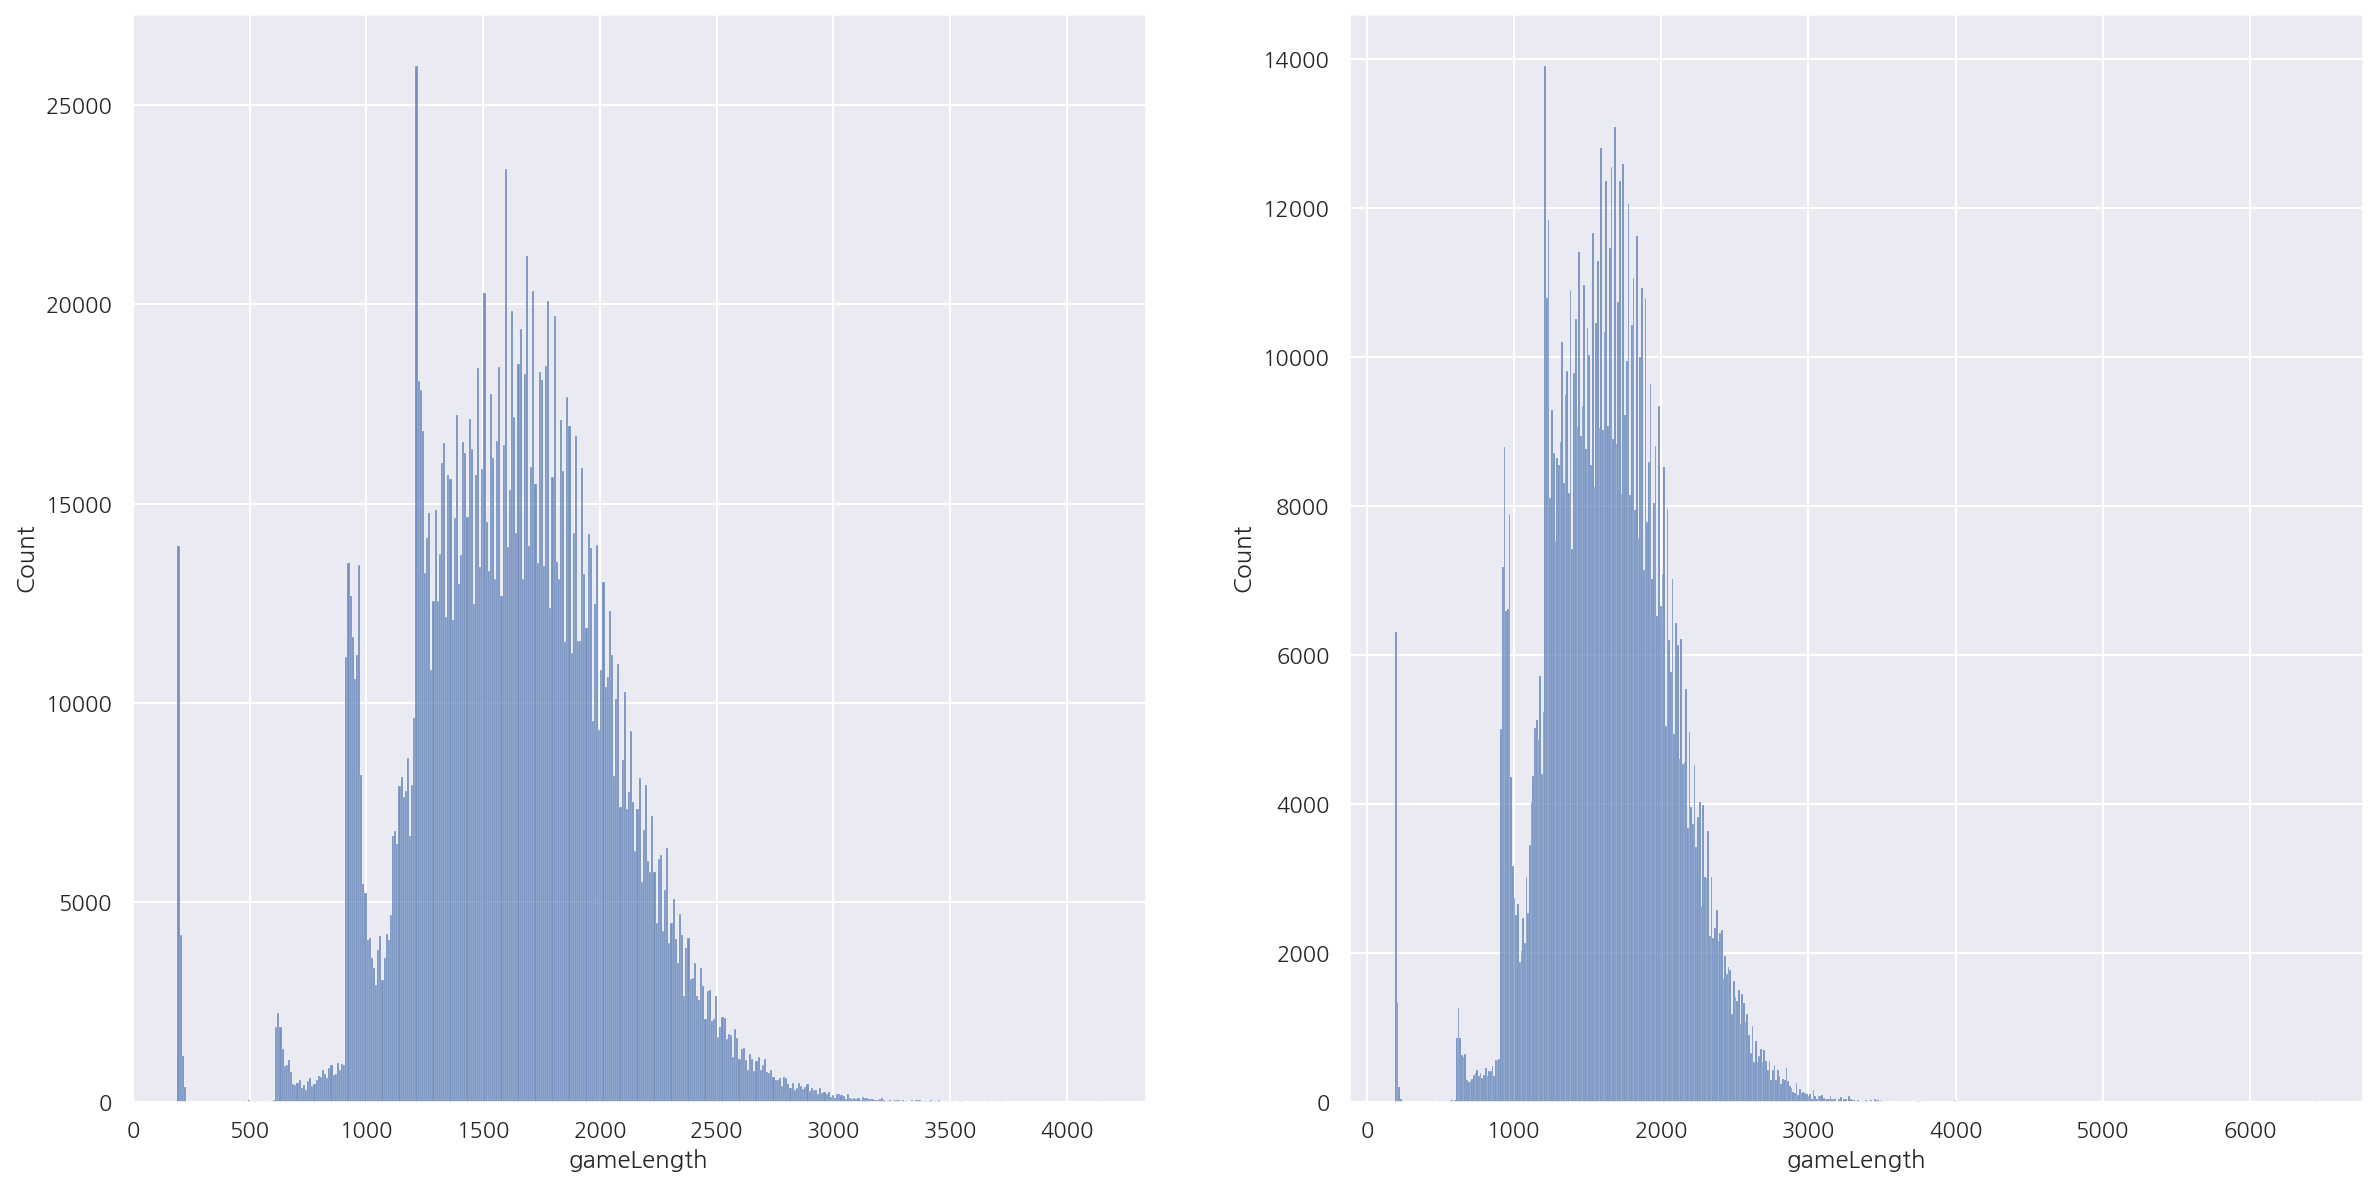

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# histplot
sns.histplot(train["gameLength"], ax=axs[0])
sns.histplot(test["gameLength"], ax=axs[1])
plt.show()

- 두 데이터 셋의 게임시간 분포는 비슷한 형태로 나타났다.


- test의 경우 게임시간이 매우 높은 이상값이 존재해 보인다.


- 분포는 대략 다시하기, 조기항복~20분서랜에 많은 빈도가 보이며 이후 시간대는 일반적인 형태로 나타난다.

#### 1.4.1 CS

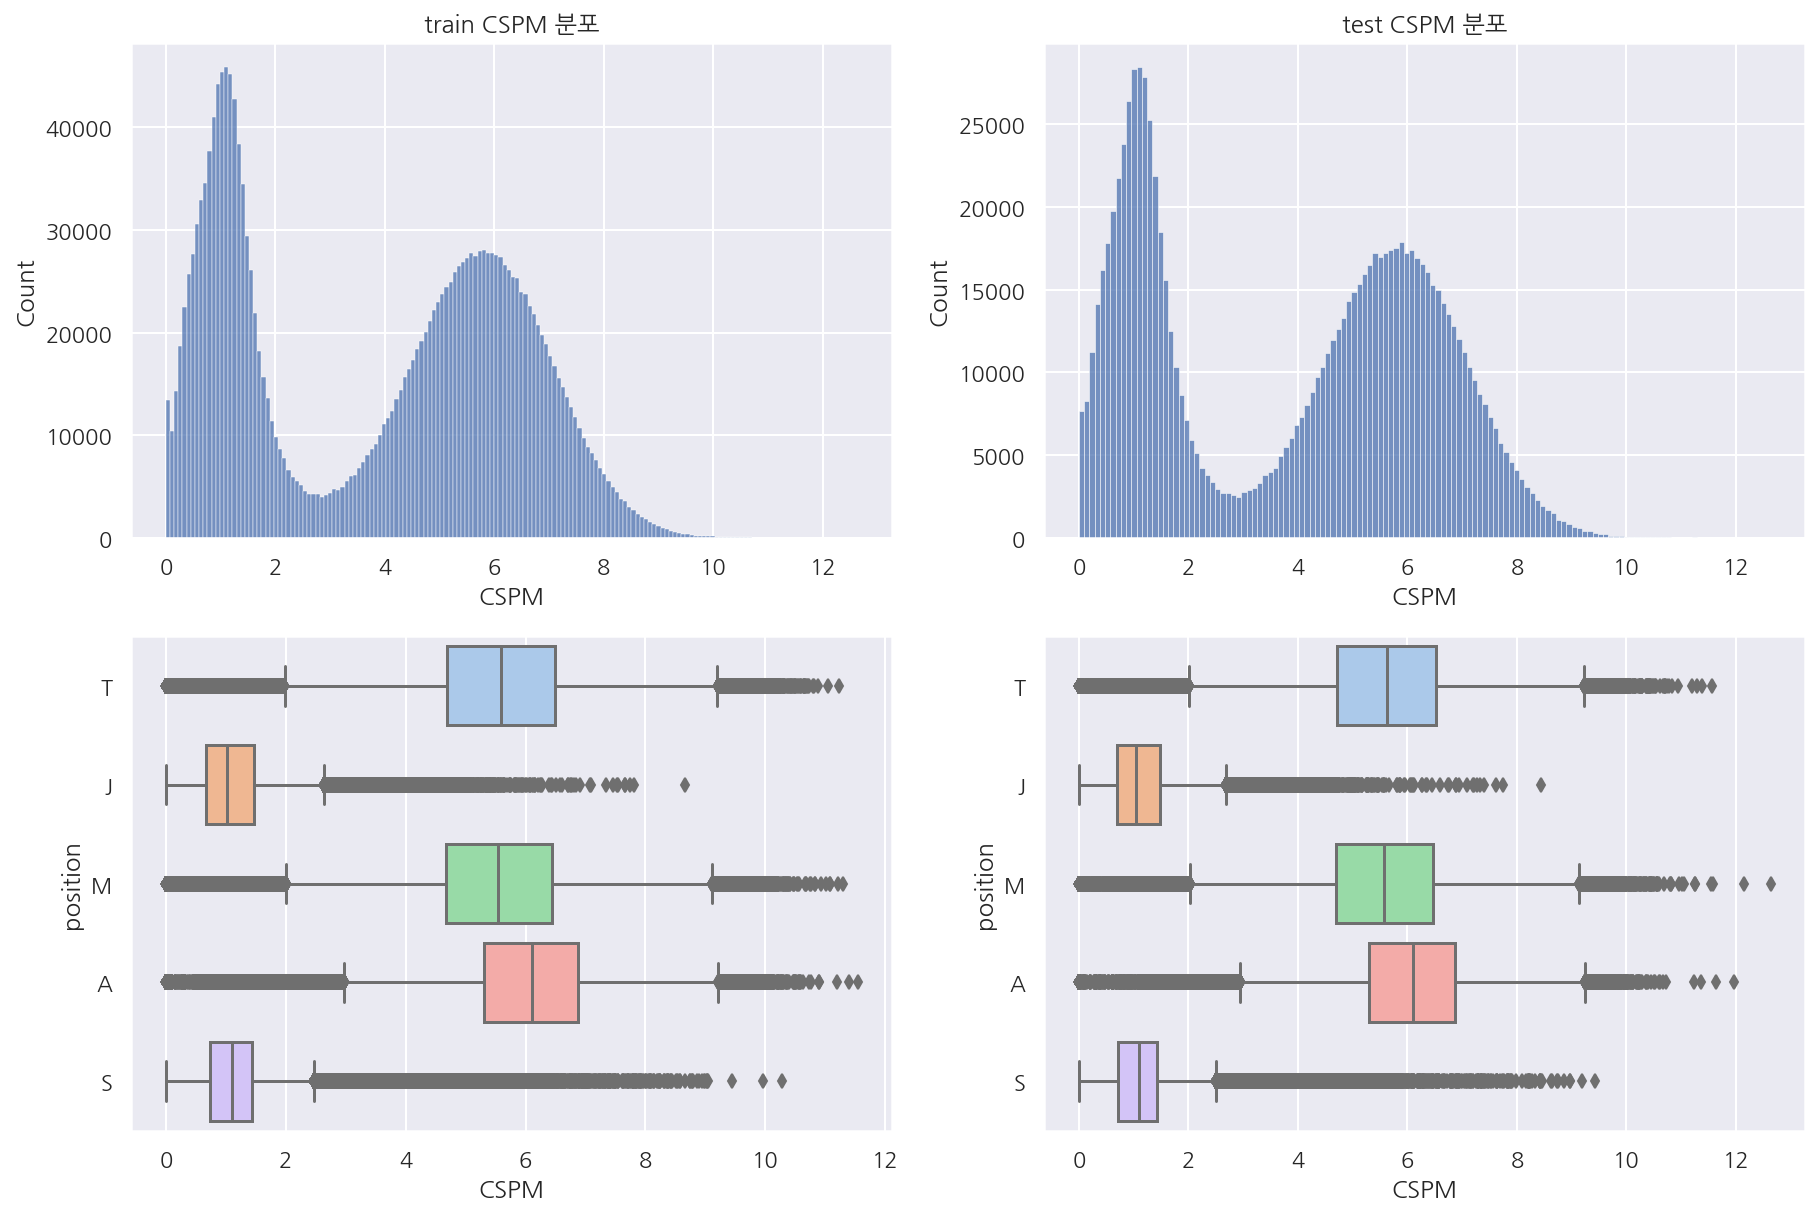

In [25]:
visualization("train", "test", "CSPM")

- 우선 분당 CS를 살펴보면 두 데이터셋의 분포는 매우 흡사하다.


- 포지션별로 보면 정글, 서폿은 다른 포지션에 비해 CS가 적어보인다.


- 참고로 여기서 포지션은 OP.GG에서 이전에 예측한 값들이다.

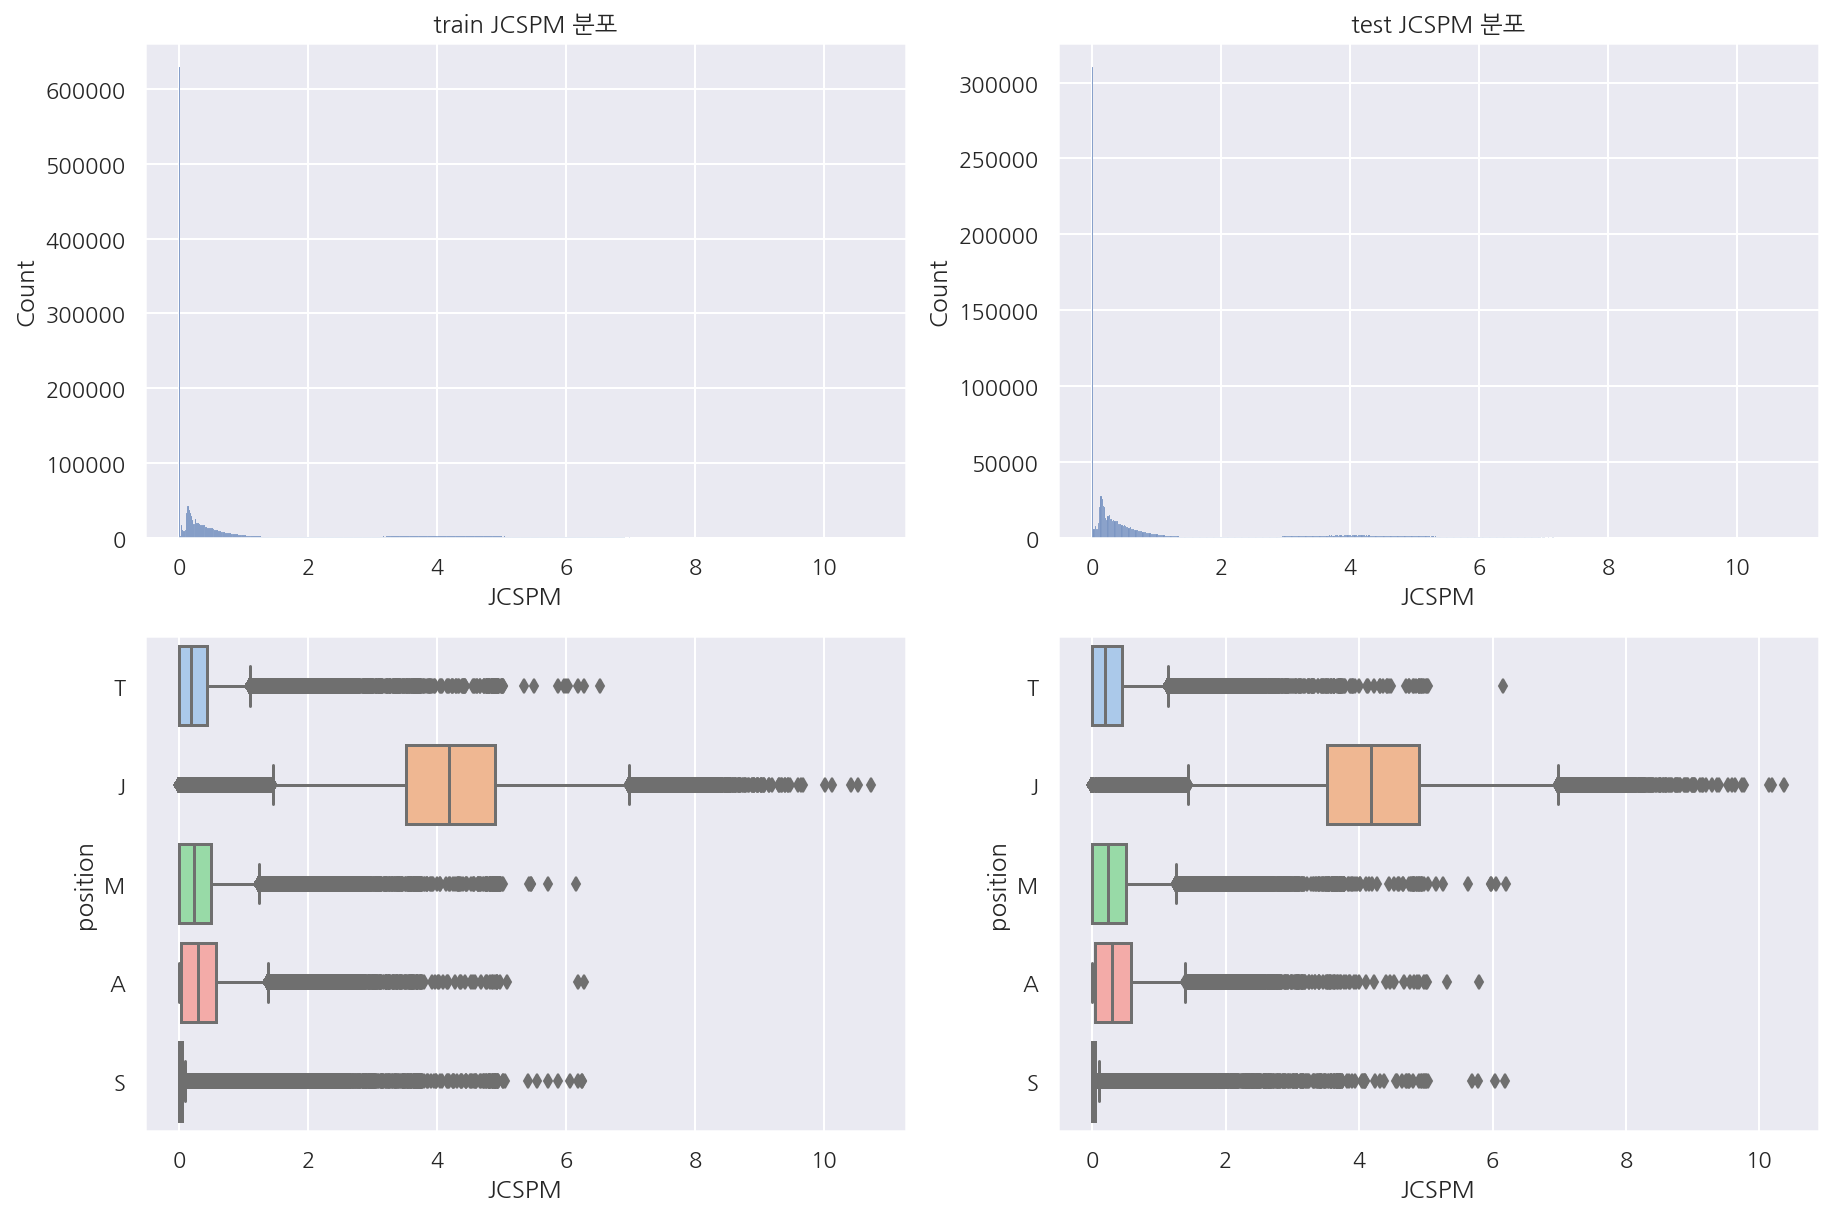

In [26]:
visualization("train", "test", "JCSPM")

- 분당 정글(중립 미니언) CS 역시 분포는 비슷해 보이나 0이 매우 많음을 알 수 있다.


- 이는 게임시간, 티어, 포지션 등 다양한 이유가 있을 것이나 자세히 뜯어보진 않았다.


- 이 변수로는 정글이 확실히 다른 포지션에 비해 눈에 띈다.

In [27]:
temp = train[train["JCSPM"]==0].position.value_counts().reset_index()
temp["rate"] = temp["position"] / temp["position"].sum()

print(temp["position"].sum())
temp

629567


,index,position,rate
0,S,294796,0.468252
1,T,121825,0.193506
2,M,111905,0.177749
3,A,99318,0.157756
4,J,1723,0.002737


- 전체 200만 건 중 62만건이 0

In [28]:
temp = test[test["JCSPM"]==0].position.value_counts().reset_index()
temp["rate"] = temp["position"] / temp["position"].sum()

print(temp["position"].sum())
temp

310325


,index,position,rate
0,S,146758,0.472917
1,T,59082,0.190387
2,M,54809,0.176618
3,A,48900,0.157577
4,J,776,0.002501


- 전체 100만 건 중 31만건이 0


- train, test 모두 분당 정글 CS가 0인 경우의 비율이 포지션별로 비슷하다.

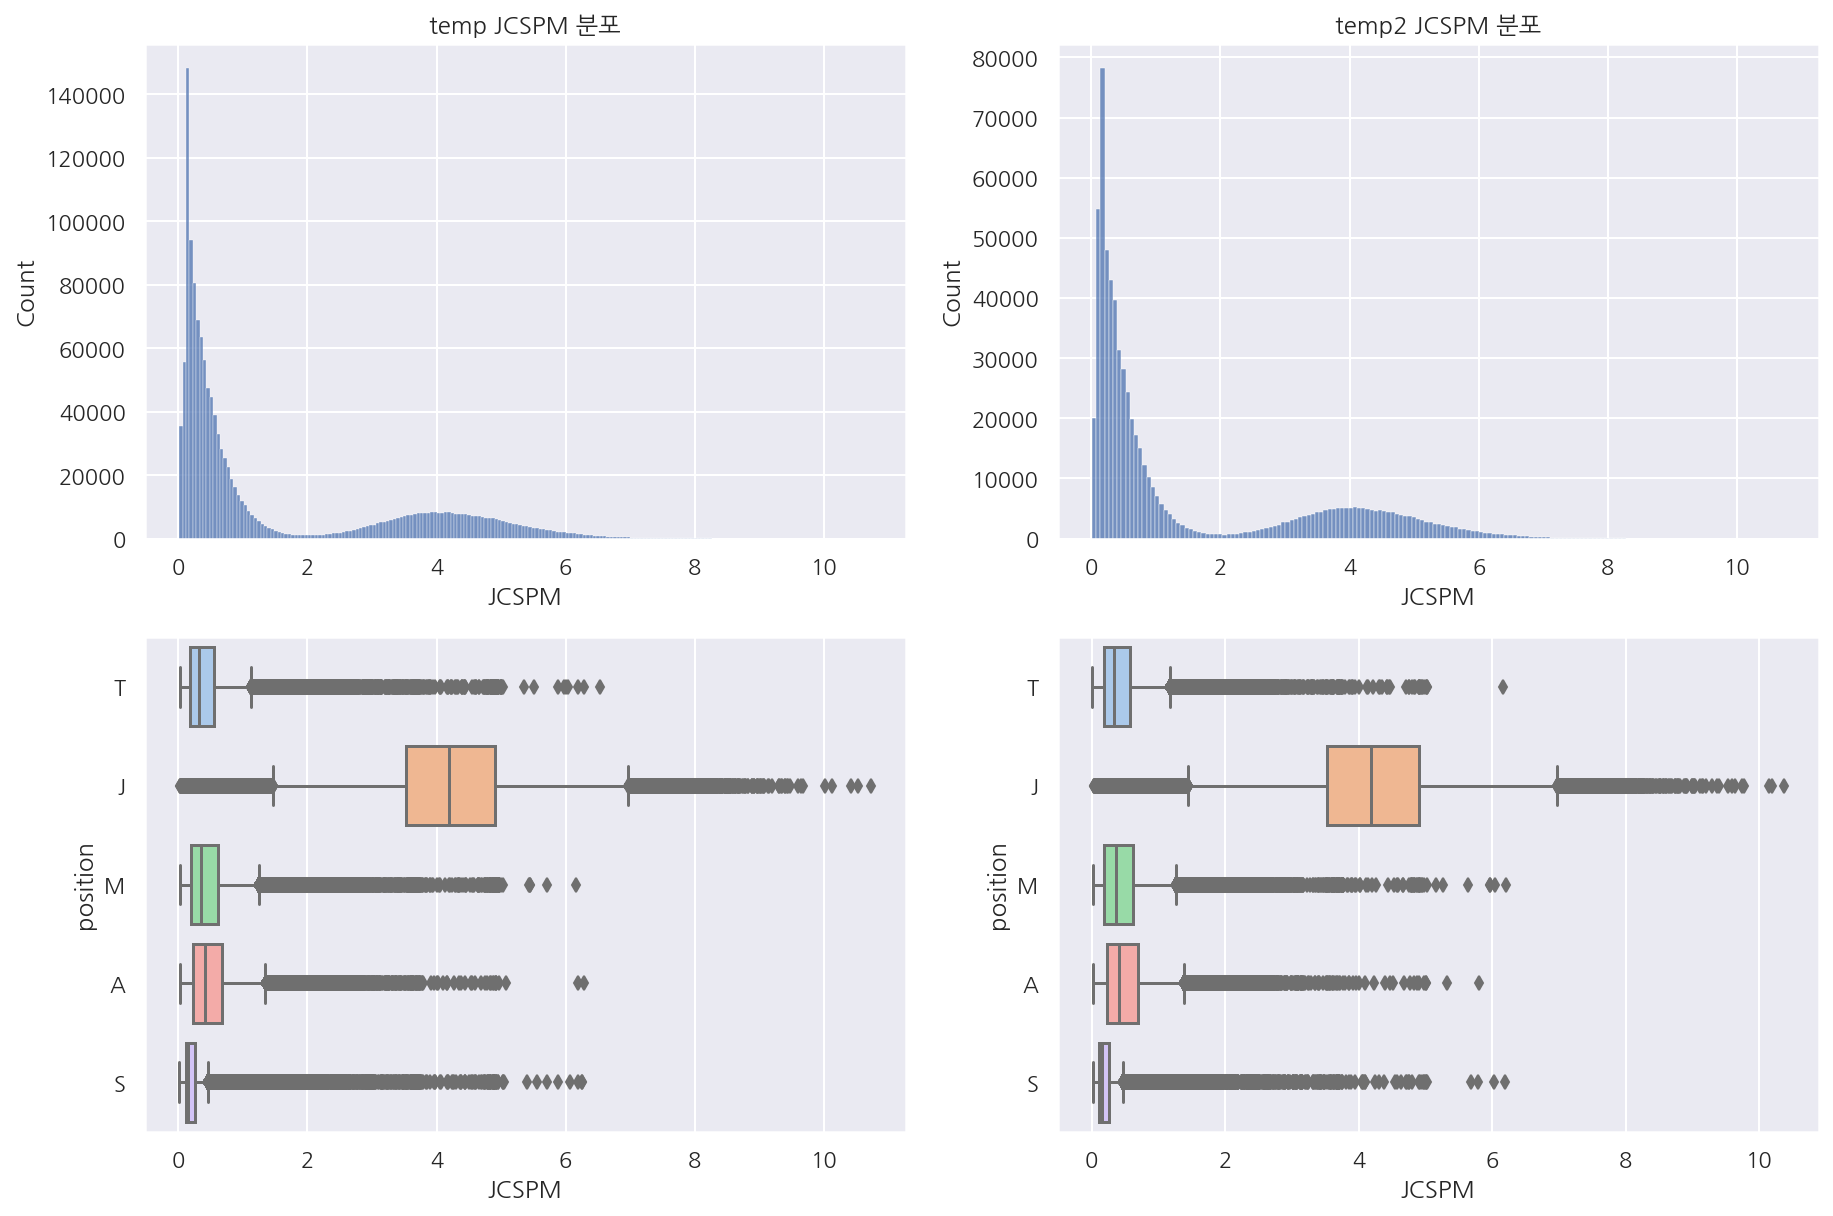

In [29]:
temp = train[train["JCSPM"]!=0]
temp2 = test[test["JCSPM"]!=0]
visualization("temp", "temp2", "JCSPM")

- 0 값을 제외하고 보면 두 데이터 셋의 분포가 거의 동일함을 보인다.


- 앞서 0인 경우 포지션별 비율도 비슷하였고 0이 아닌 경우는 비슷한 분포이기에 이상값 처리는 하지 않으려 한다.

#### 1.4.2 와드

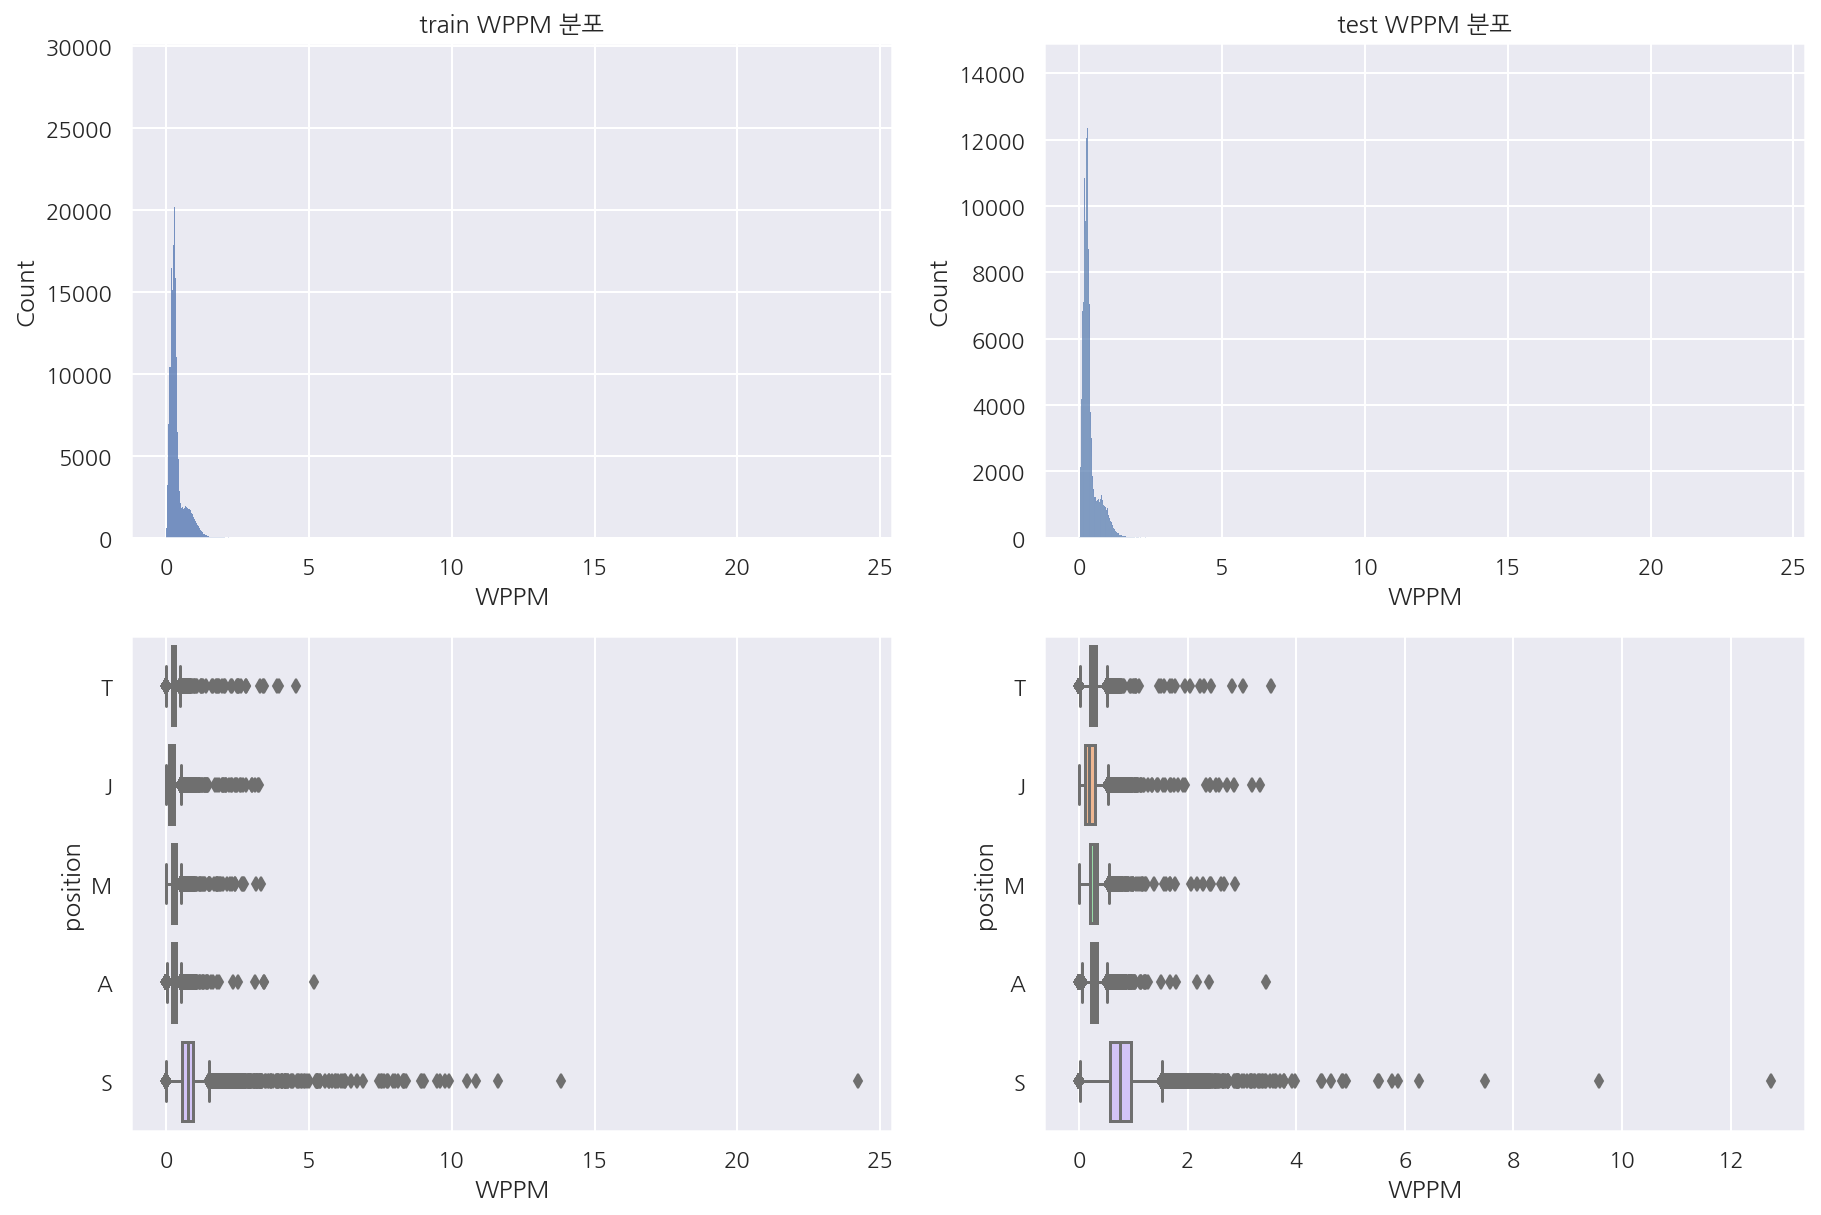

In [30]:
visualization("train", "test", "WPPM")

- 와드 설치의 경우 서폿이 많은 것이 보인다.


- 시야 아이템이 없다면 제어와드는 최대 2개 소지 가능할텐데 분당 5개가 넘는다면 좀 이상함(제어:2,기본:2)


- 서폿의 경우 시야 아이템 + 제어와드 + (경계의 와드석) 고려하면 6개는 가능하겠지만 템이 나오는 시간 고려


- 템이 나왔더라도 1분마다 설치, 귀환, 설치, 귀환으로 하지 않는다면 무리가 있어보인다.


- 기본 와드 쿨타임도 고려하면 분당 3 ~ 4개가 일반적으로 많이 설치한 게 아닐까 싶다.

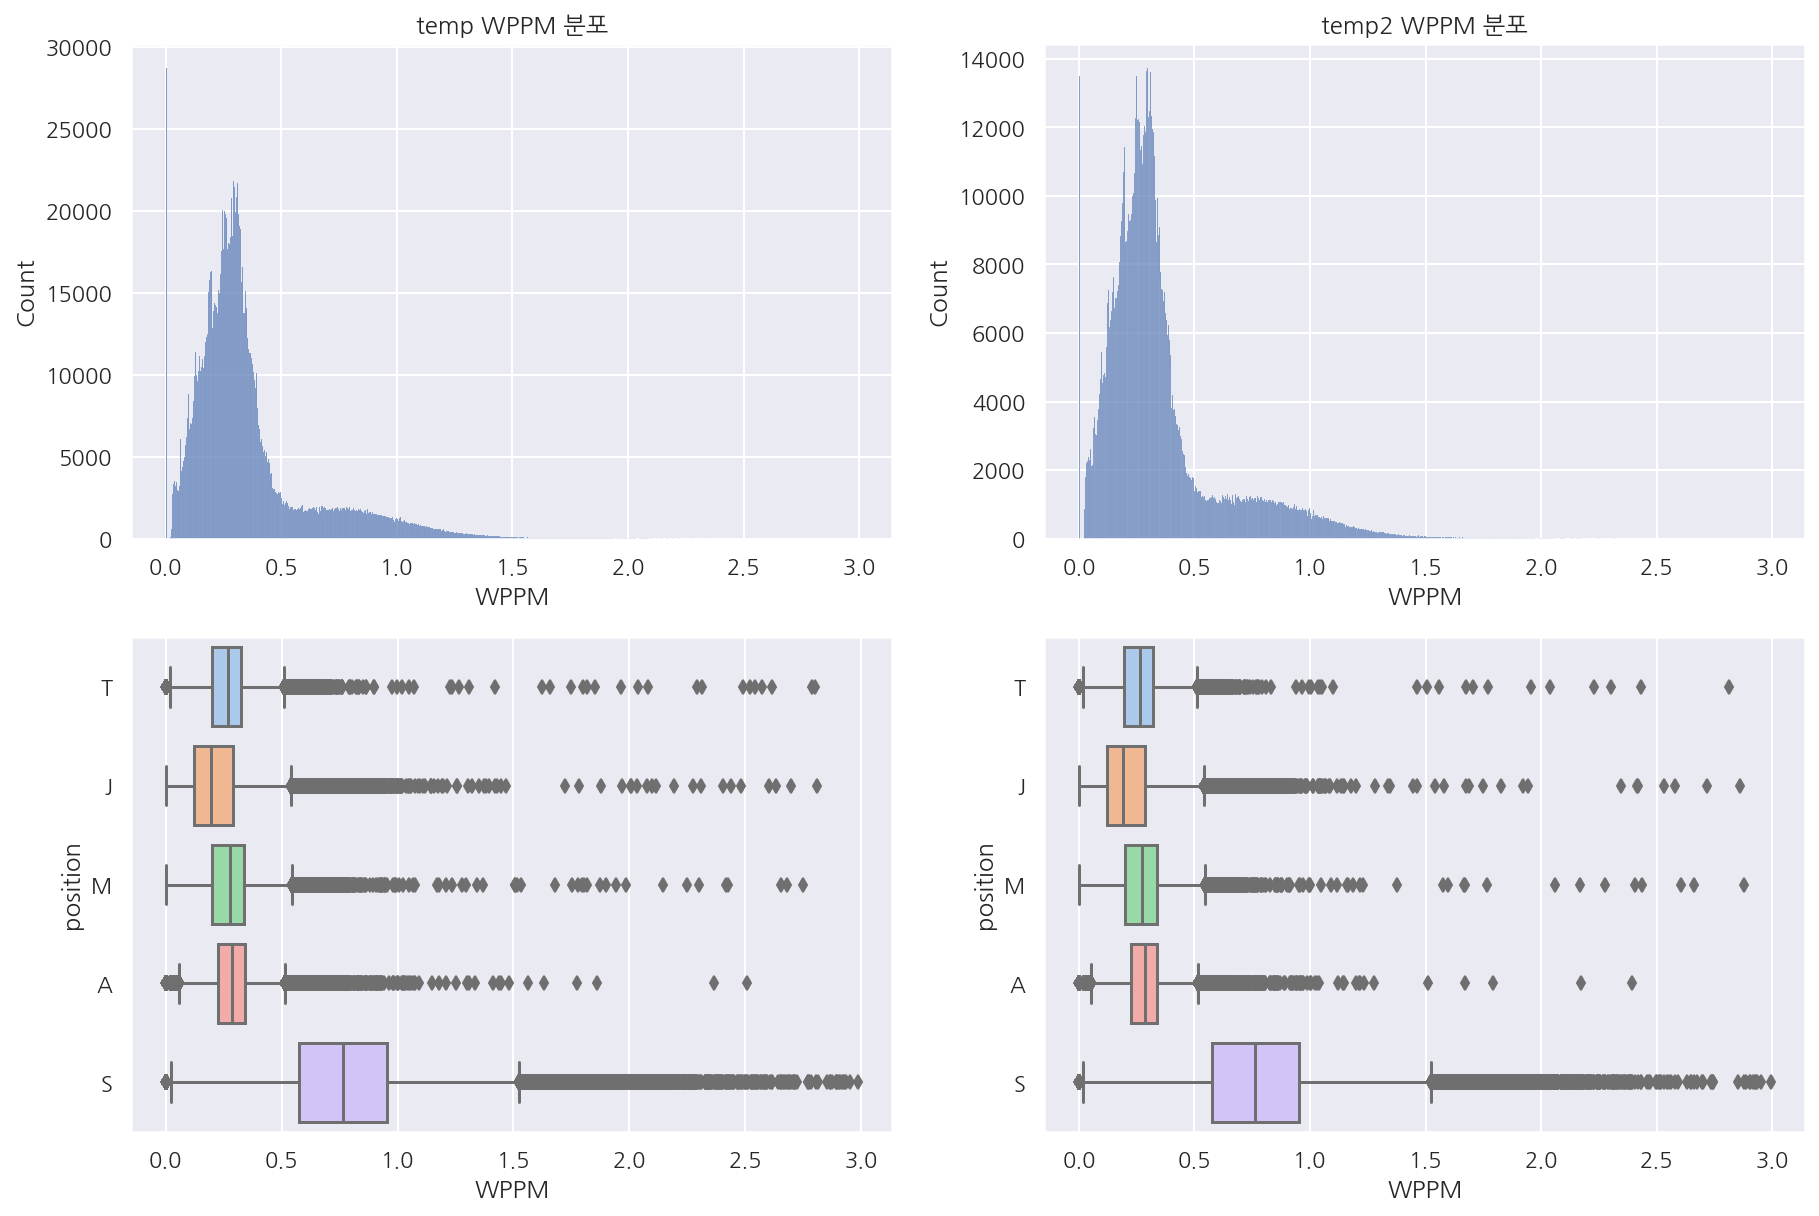

In [31]:
temp = train[train["WPPM"] <= 3]
temp2 = test[test["WPPM"] <= 3]
visualization("temp", "temp2", "WPPM")

- 분당 와드 설치 수가 3개 이하인 경우만 보았을 때 역시나 비슷한 분포를 나타낸다.


- 전체 중앙값 혹은 평균값을 기준으로 삼거나 앞서 생각한 3개 정도를 기준으로 이상값 처리를 할까 싶었다.


- 다만 이후 모델에서는 우선 그대로 사용해보았고 원하던 정보는 서폿이 와드 설치가 많다는 점이다.

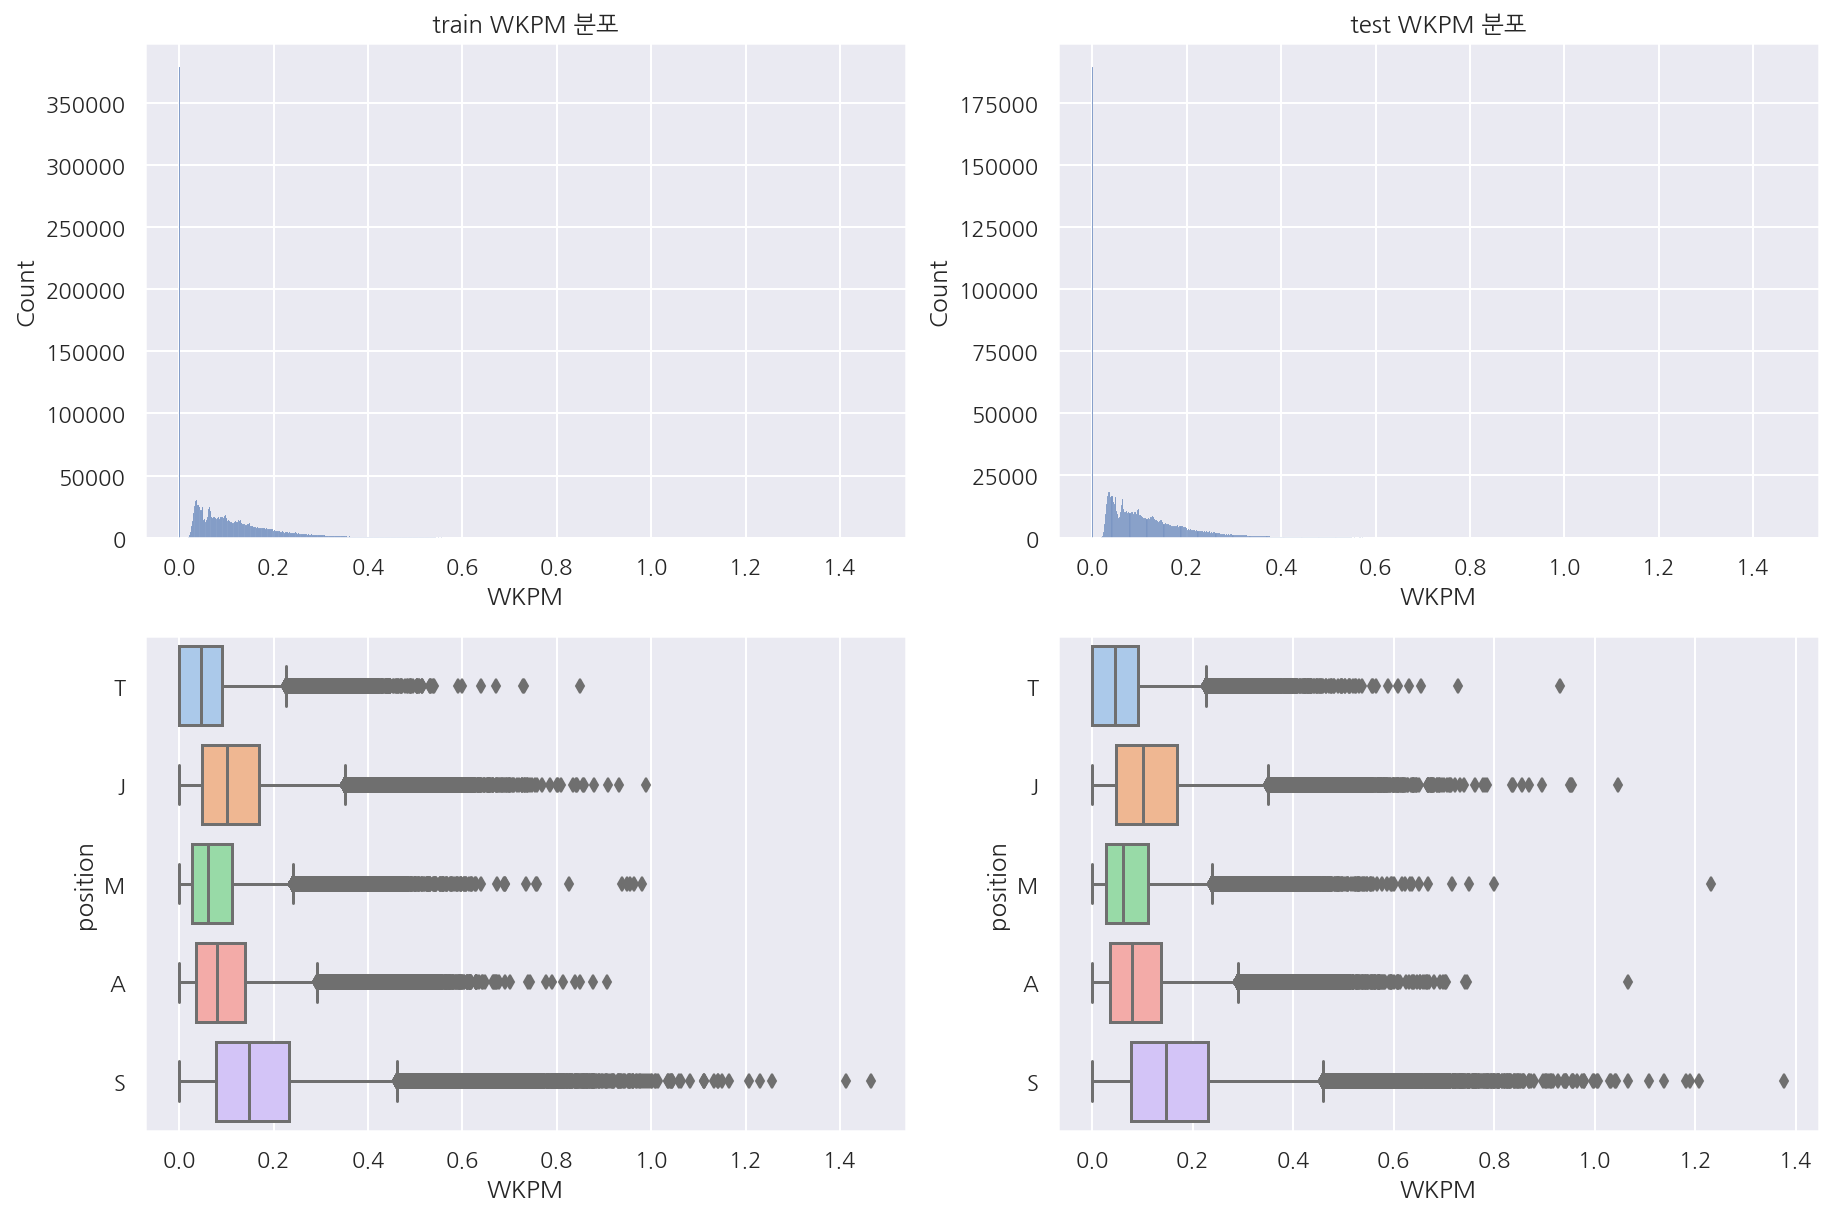

In [32]:
visualization("train", "test", "WKPM")

- 와드 제거 횟수도 서폿이 많긴 한데 확 구분되는 느낌은 아니다.


- 렌즈 돌렸을때 제거하는 사람이 누구냐에 따라 이 횟수가 추가 되는 것이 아닐까?


- 이에 대해선 정확하게 어떻게 데이터가 쌓이는 지는 모르겠다.

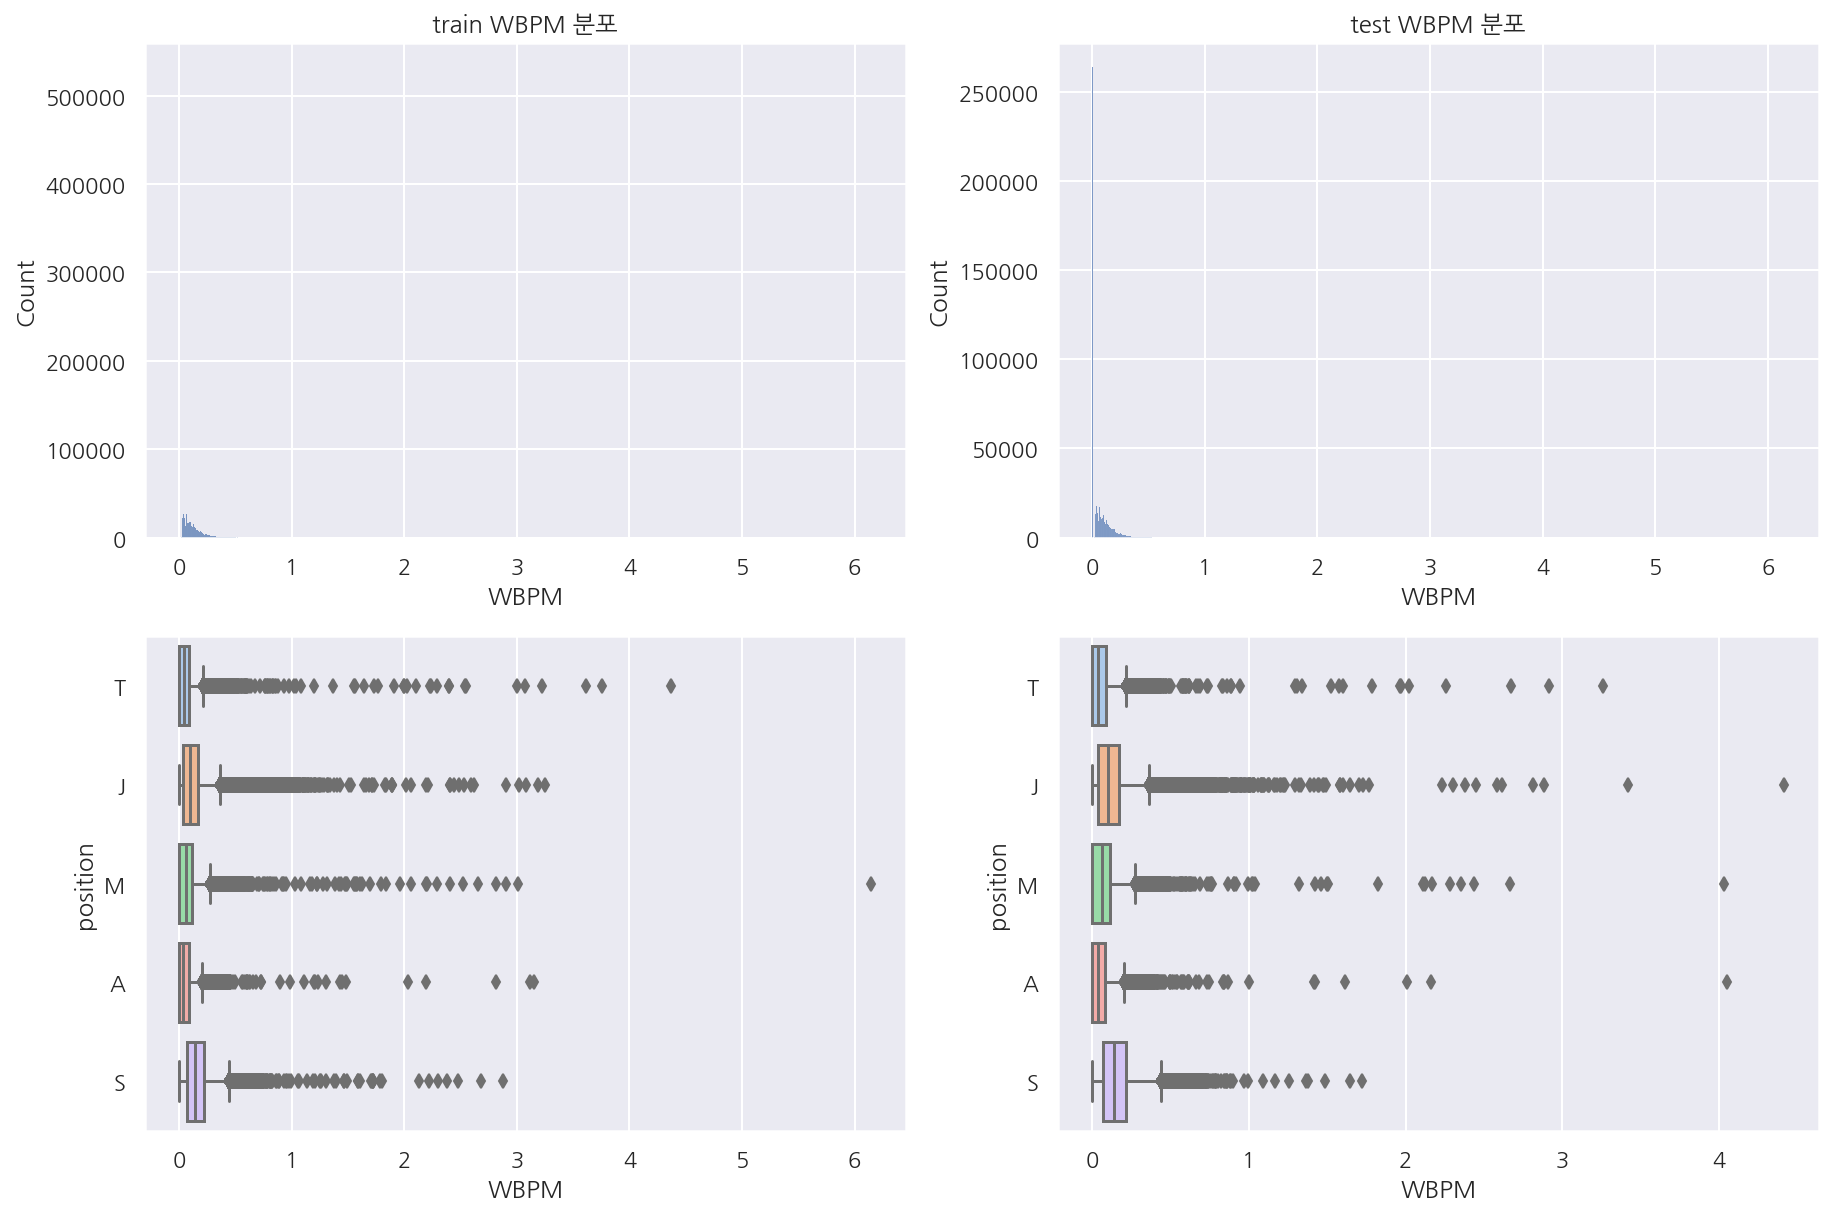

In [33]:
# visualization("train", "test", "visionWardsBoughtInGame")
visualization("train", "test", "WBPM")

- 제어와드 구매 횟수를 분 단위로 확인하였을 때 0이 많고 포지션별로 뚜렷한 차이는 안보인다.


- 역시나 티어별로 구분해서 본다면 다르게 나타날 수도 있을 것 같다.

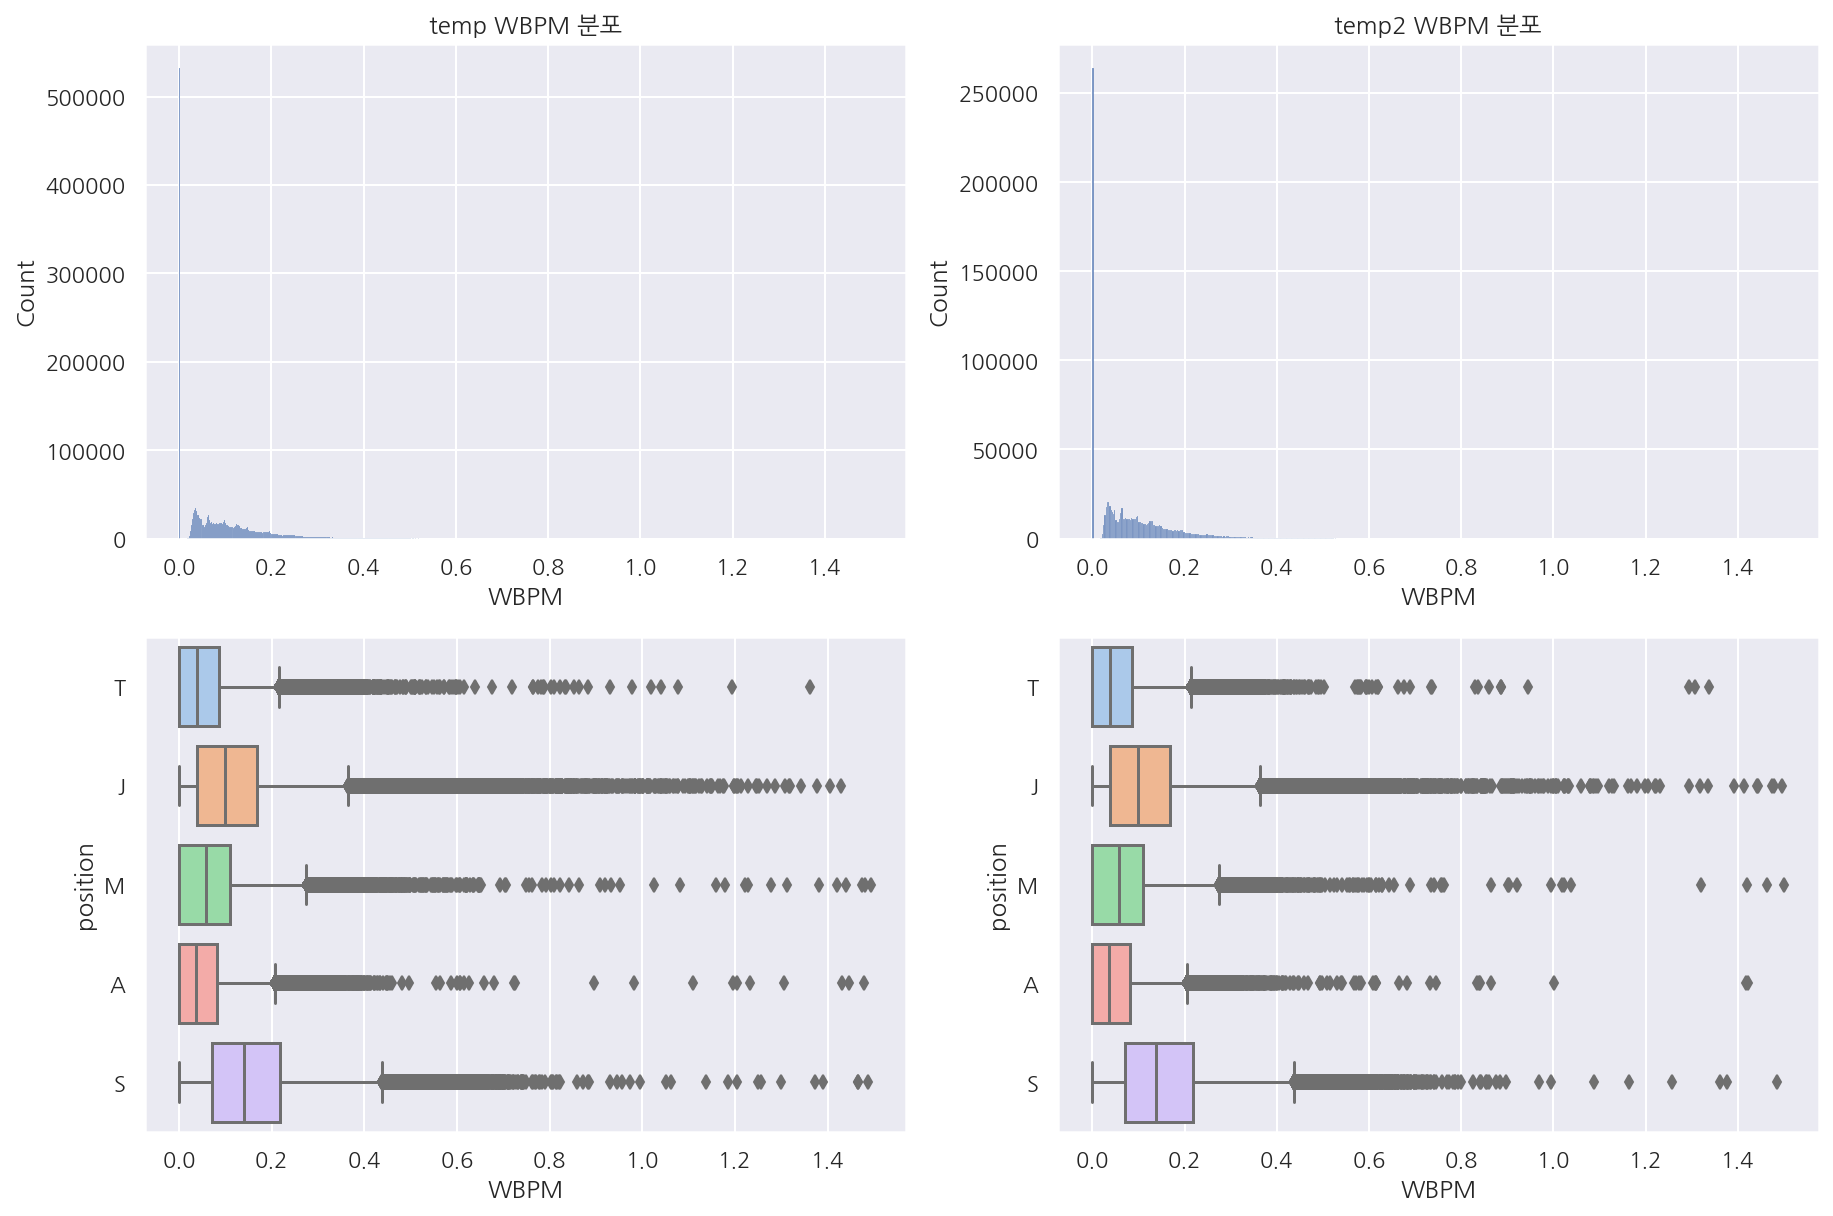

In [34]:
temp = train[train["WBPM"] <= 1.5]
temp2 = test[test["WBPM"] <= 1.5]
visualization("temp", "temp2", "WBPM")

- 포지션별 상자 그림이 눈에 안띄어서 일부 편집해서 보았는데 역시 큰 차이는 안보인다.

#### 1.4.3 KDA

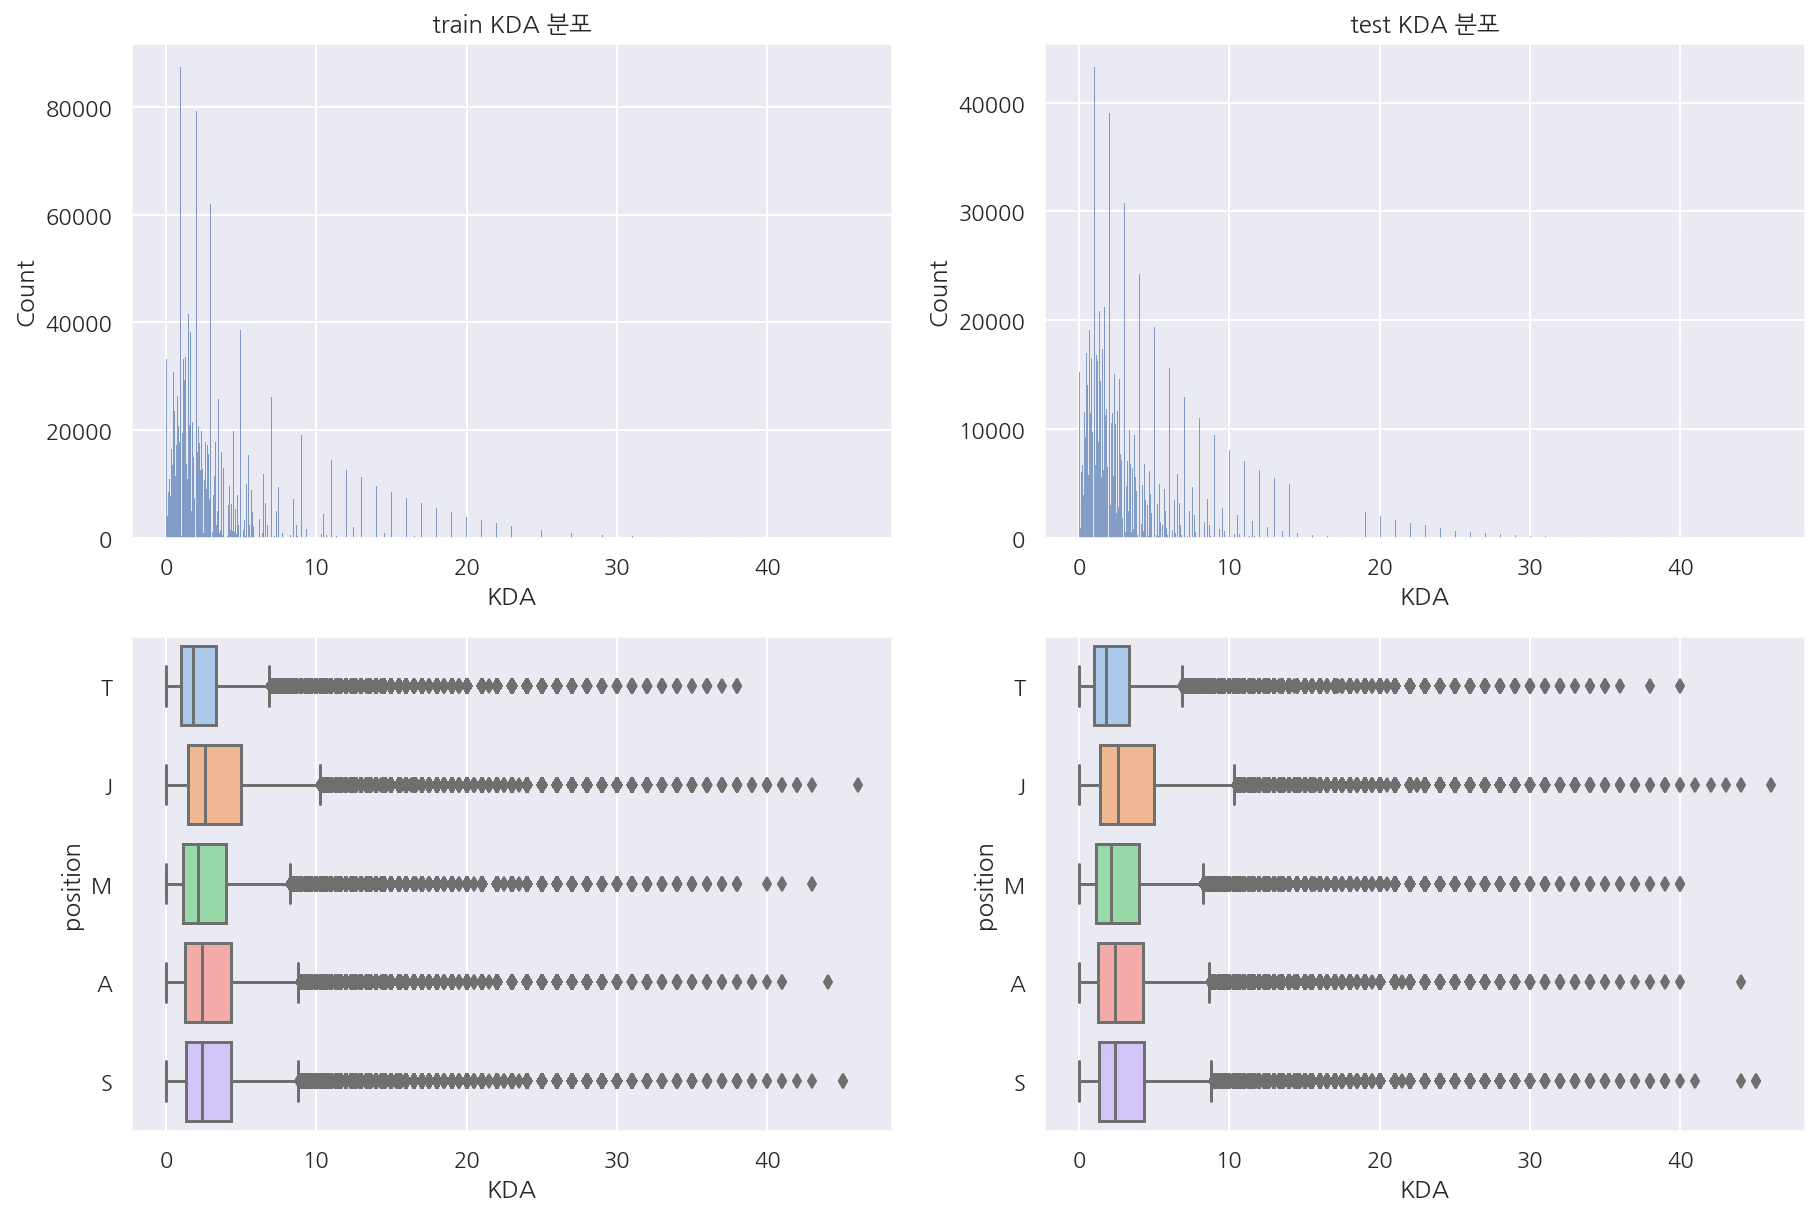

In [36]:
visualization("train", "test", "KDA")

- 예상한대로 KDA는 딱히 포지션 구분이 되는 변수는 아닌 듯 하다.

#### 1.4.4 스펠

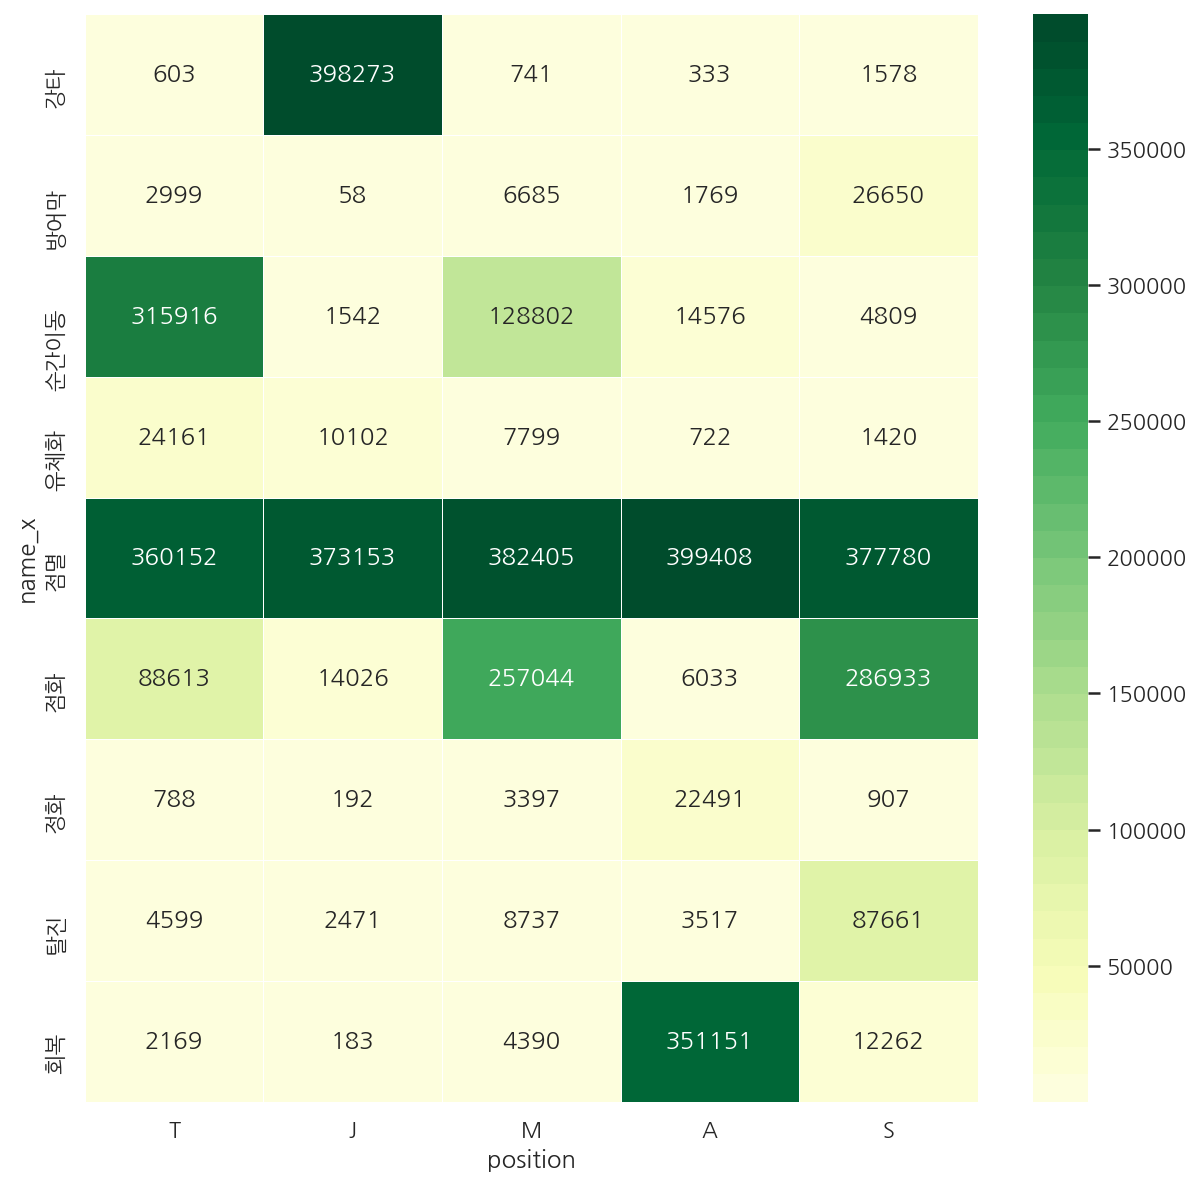

In [37]:
# train 스펠
temp = train[["position","spell1","spell2"]]
temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
temp2 = temp.groupby(["position","name_x"]).size().unstack("name_x")
temp3 = temp.groupby(["position","name_y"]).size().unstack("name_y")
temp4 = temp2 + temp3

fig, axs = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(temp4.T, fmt="d", cmap=sns.color_palette("YlGn", 40),linewidths=0.5, annot=True)
plt.show()

- train에서 포지션별로 어떤 스펠을 사용하였는지 확인하였다.


- 점멸은 포지션을 떠나 가장 많았고 각 포지션별로 나름 눈에 띄는 스펠들이 있다.


- 원딜의 경우 회복, 정화 등이 다른 포지션에 비해 눈에 띈다.

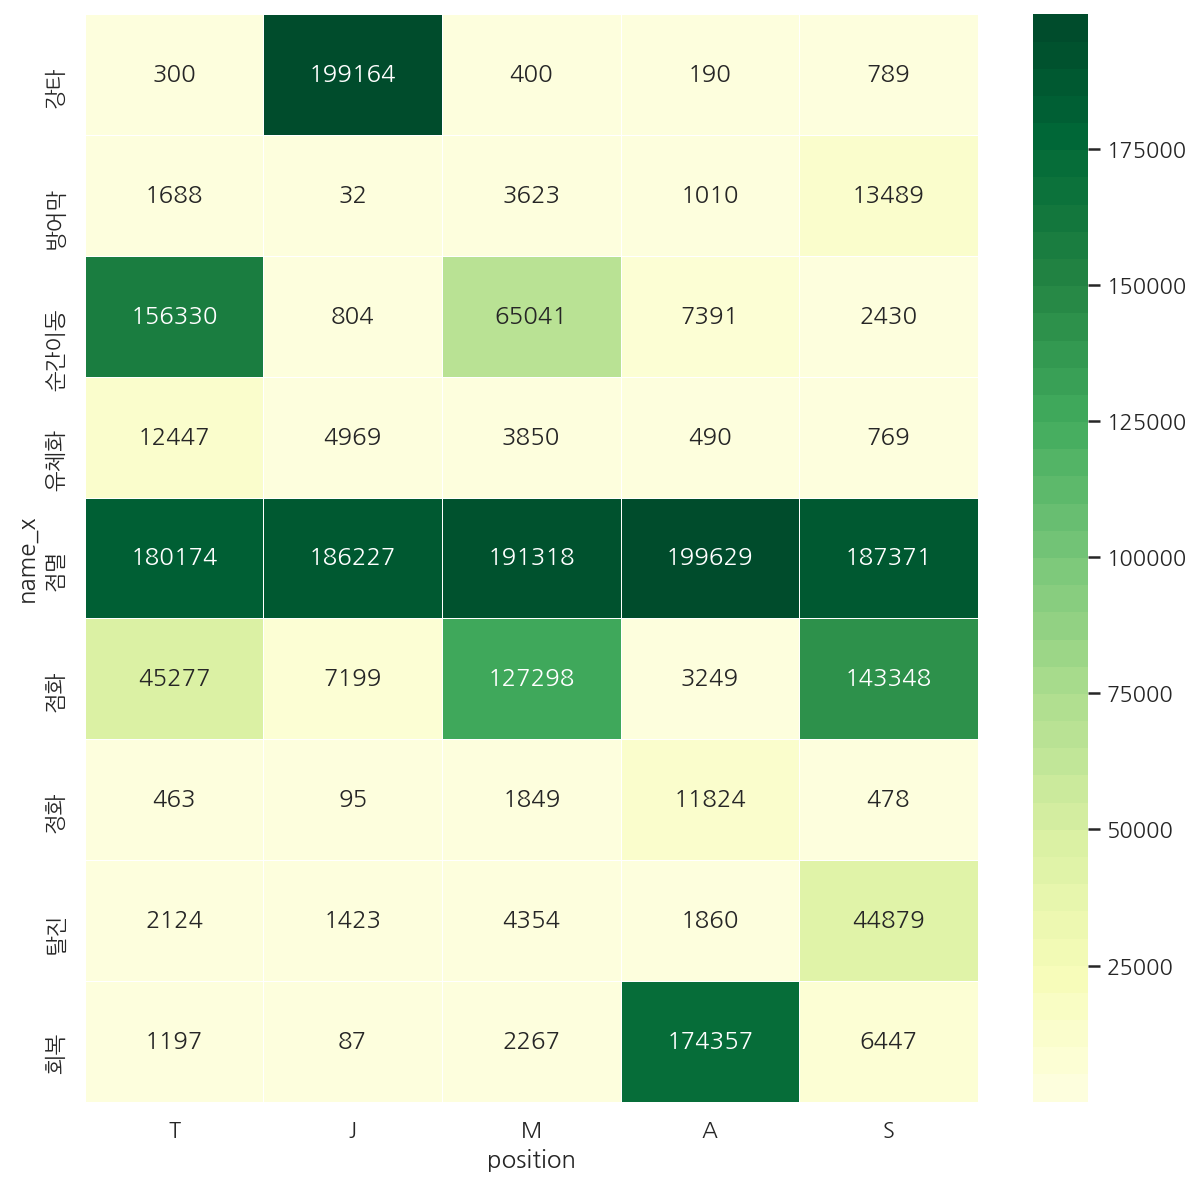

In [38]:
# test 스펠
temp = test[["position","spell1","spell2"]]
temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
temp2 = temp.groupby(["position","name_x"]).size().unstack("name_x")
temp3 = temp.groupby(["position","name_y"]).size().unstack("name_y")
temp4 = temp2 + temp3

fig, axs = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(temp4.T, fmt="d", cmap=sns.color_palette("YlGn", 40),linewidths=0.5, annot=True)
plt.show()

- test 역시 비슷한 형태

In [39]:
# 스펠 순서 함수 (점멸/점화, 점화/점멸 똑같으므로)
def spell_order(x):
    if x["spell1"] < x["spell2"]:
        result = x["name_x"] + "/" + x["name_y"]
    else:
        result = x["name_y"] + "/" + x["name_x"]
    
    return result

def spell_heatmap(df, rate=False):
    # 스펠 조합 만들기 (순서는 key값이 작은게 앞으로)
    temp = df[["position","spell1","spell2"]]
    temp = pd.merge(temp, spell_df, left_on="spell1", right_on="key", how="left").drop("key", axis=1)
    temp = pd.merge(temp, spell_df, left_on="spell2", right_on="key", how="left").drop("key", axis=1)
    temp["comb"] = temp.apply(lambda x: spell_order(x), axis=1)

    # 포지션(row), 스펠 조합(col) 별 카운트 집계
    temp2 = temp.groupby(["position","comb"]).size().unstack("comb").T
           
    # 히트맵 그리기
    fig, axs = plt.subplots(1,1, figsize=(20,20))
    
    # 비율 혹은 카운트로 확인
    if rate == True:
        for col in temp2.columns:
            temp2[col] = np.round(temp2[col] / temp2[col].sum(), 2)
        sns.heatmap(temp2, fmt='.2f', linewidths=0.5, cmap=sns.color_palette("YlGn", 10), annot=True)
    else:
        sns.heatmap(temp2, fmt="d", linewidths=0.5, cmap=sns.color_palette("YlGn", 40), annot=True)
    
    return plt.show()

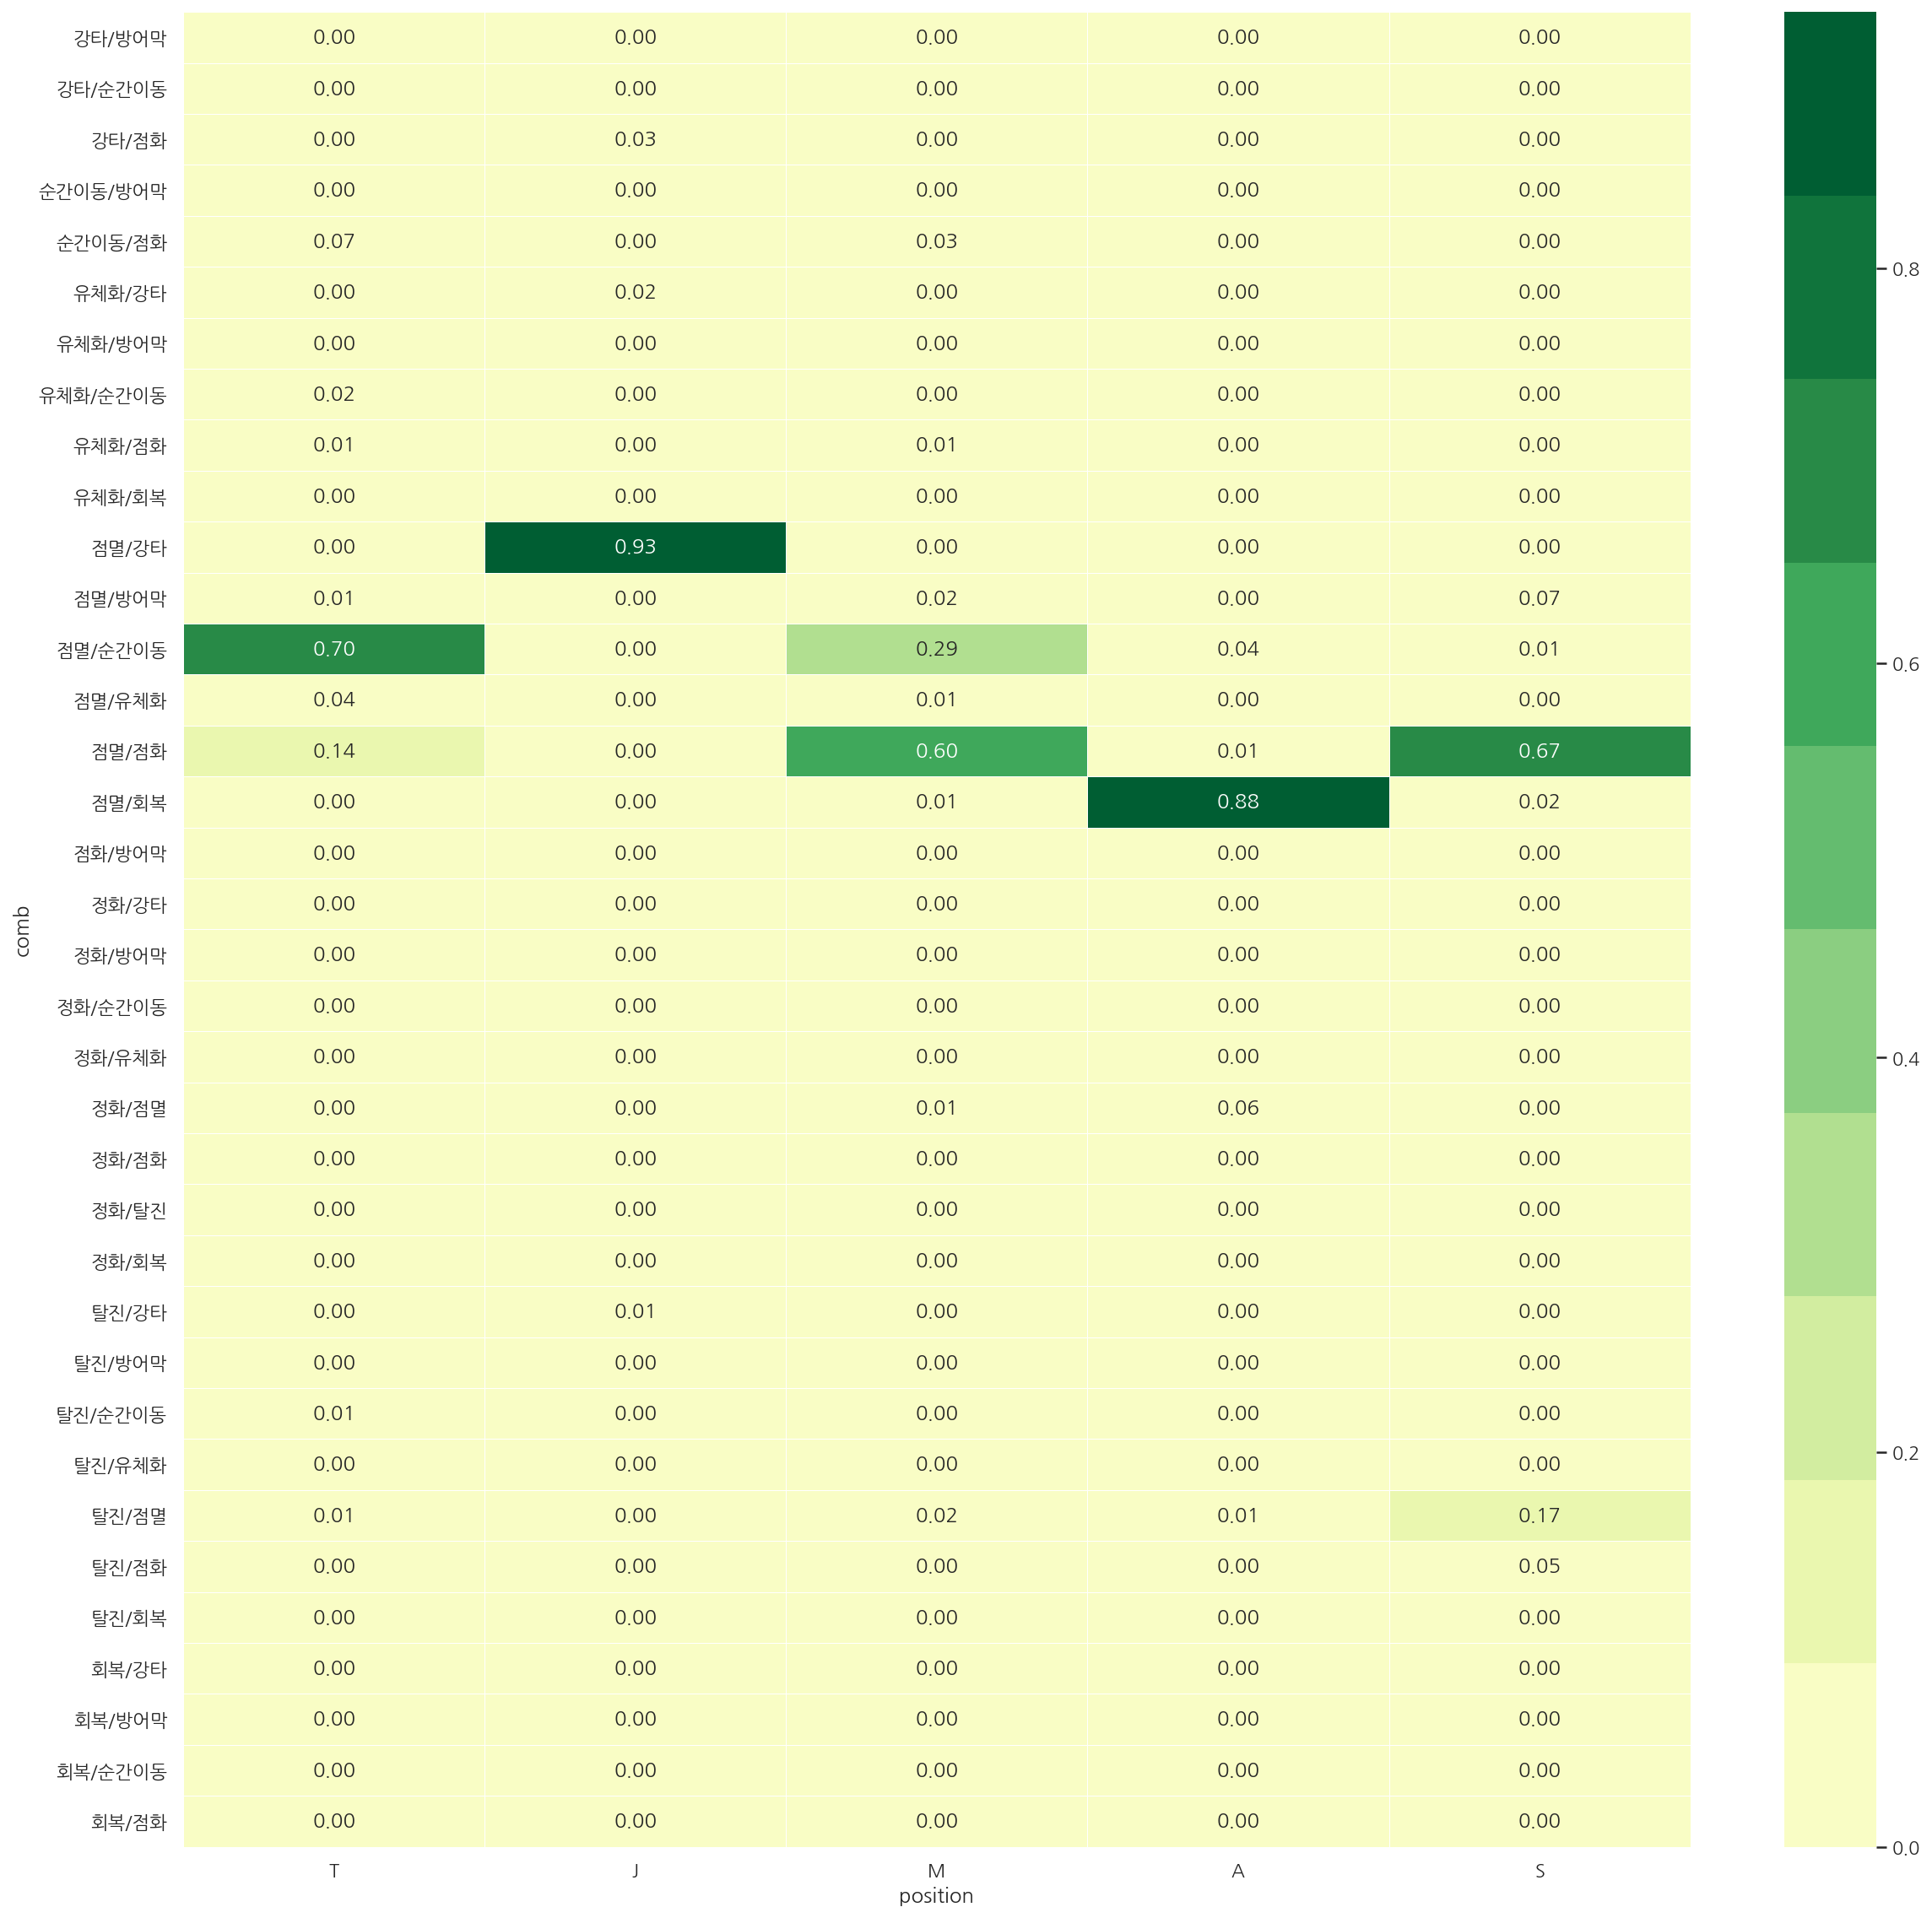

In [40]:
spell_heatmap(train, rate=True)

- 실제로 어떤 쌍의 스펠을 들었는지 보았을 때 역시 각 포지션별로 나름 구분이 된다.


- 다만 탑, 미드의 경우 서로 점멸/순간이동, 점멸/점화의 비율 순위만 다르기에 구분이 덜 될 수 있다.

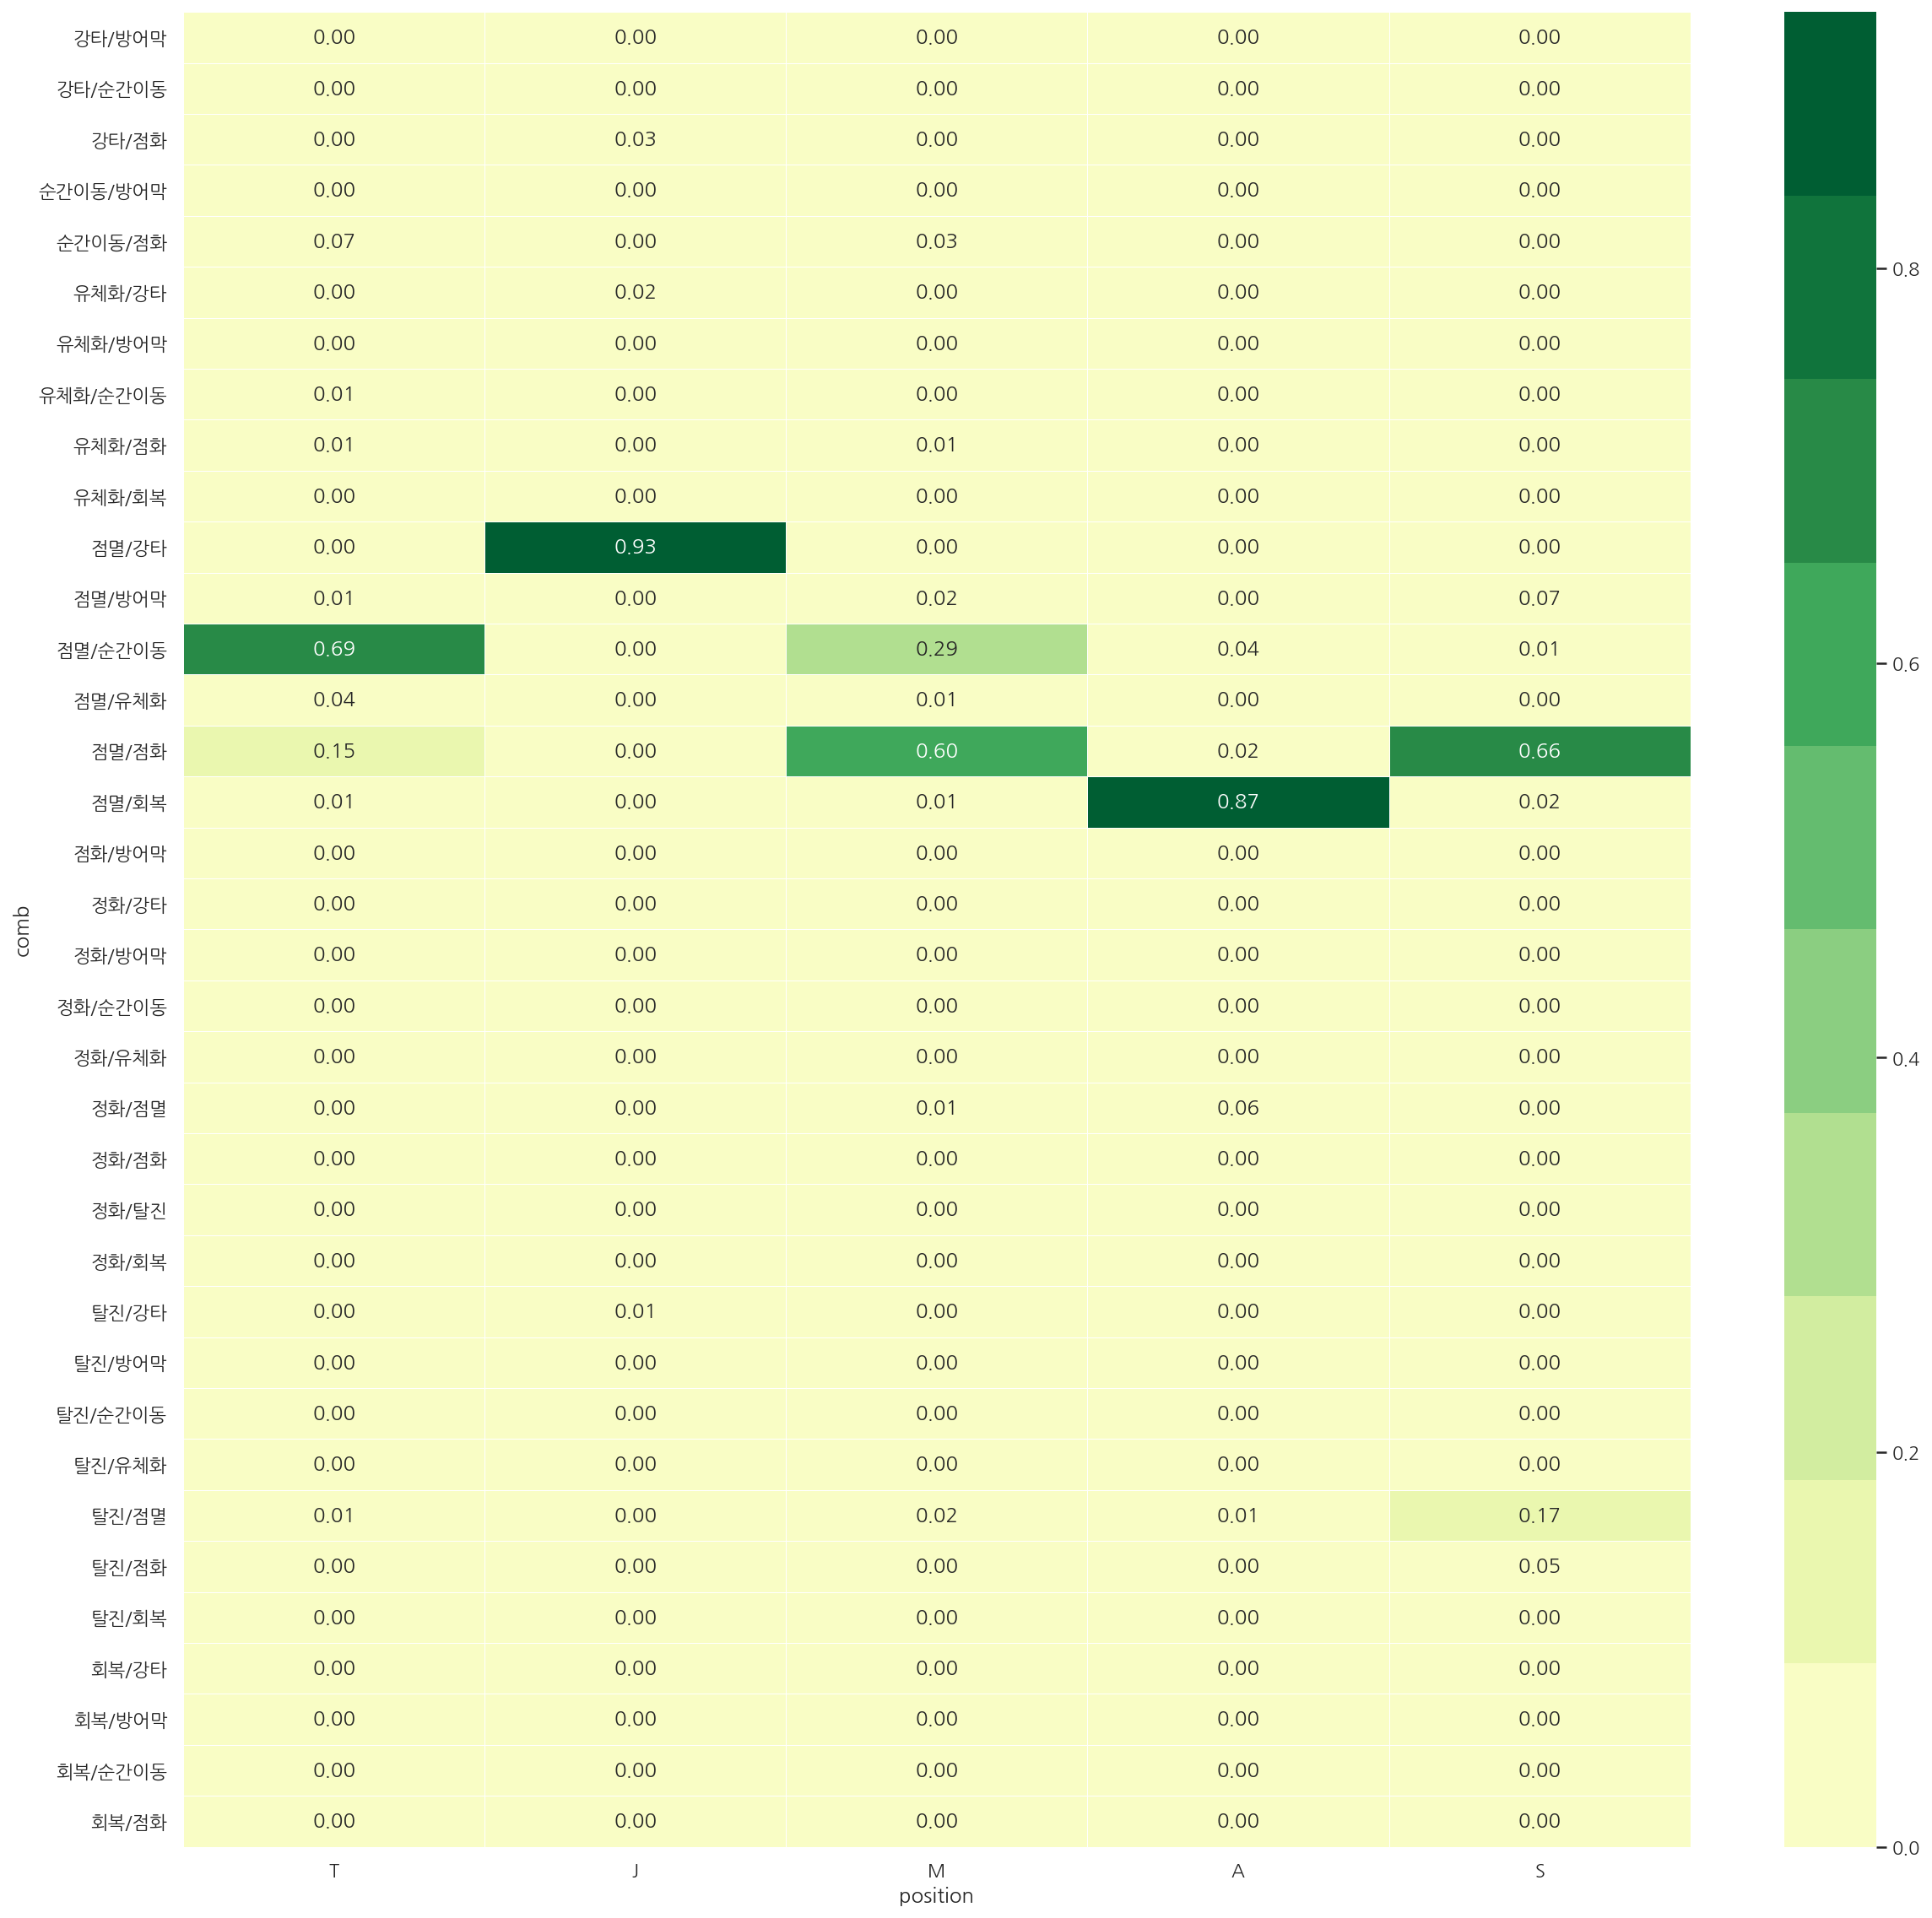

In [41]:
spell_heatmap(test, rate=True)

- train, test 전반적으로 비율은 비슷하게 나타났다.

#### 1.4.5 골드 획득

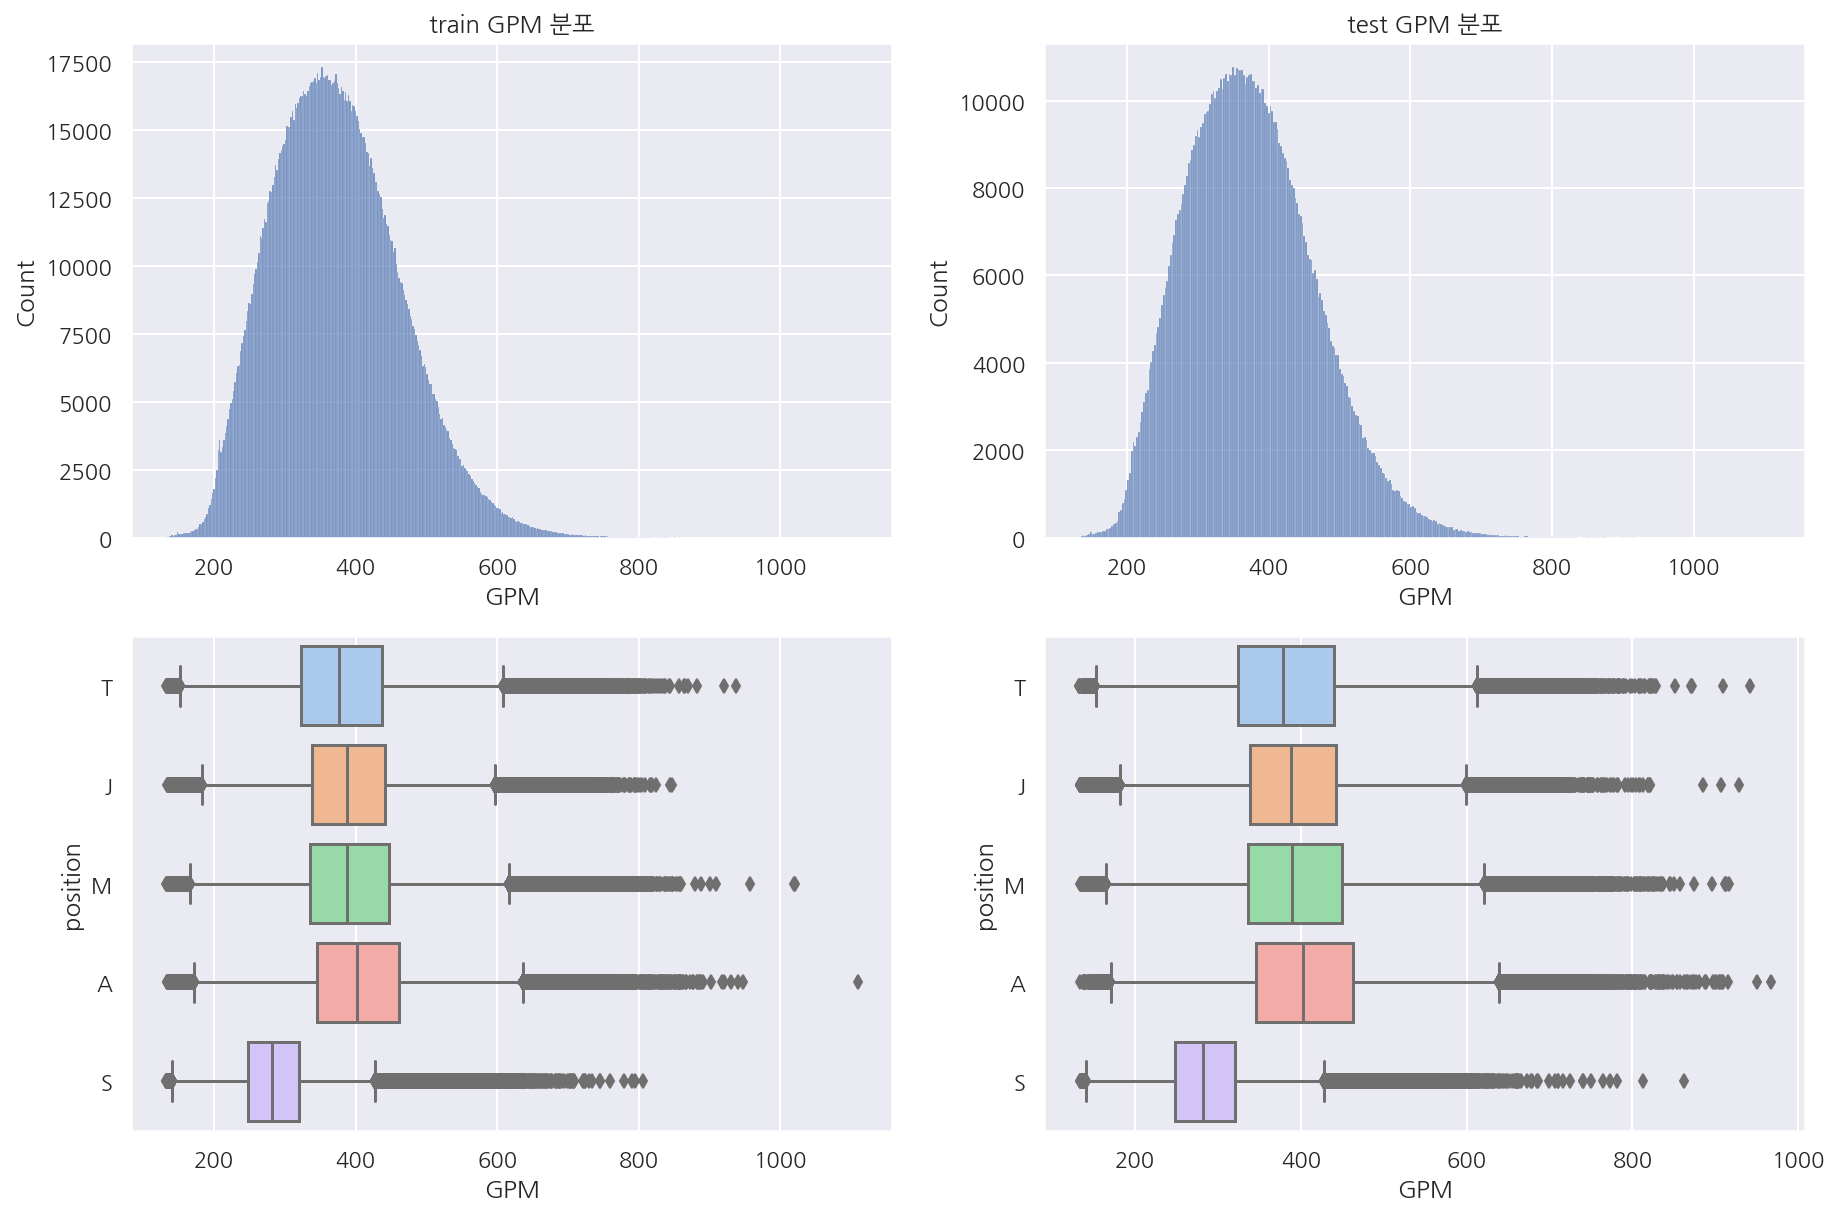

In [42]:
visualization("train", "test", "GPM")

- 분당 골드 획득량은 분포는 거의 동일하나 생각보다 포지션 구분이 잘 안된다.

#### 1.4.6 데미지

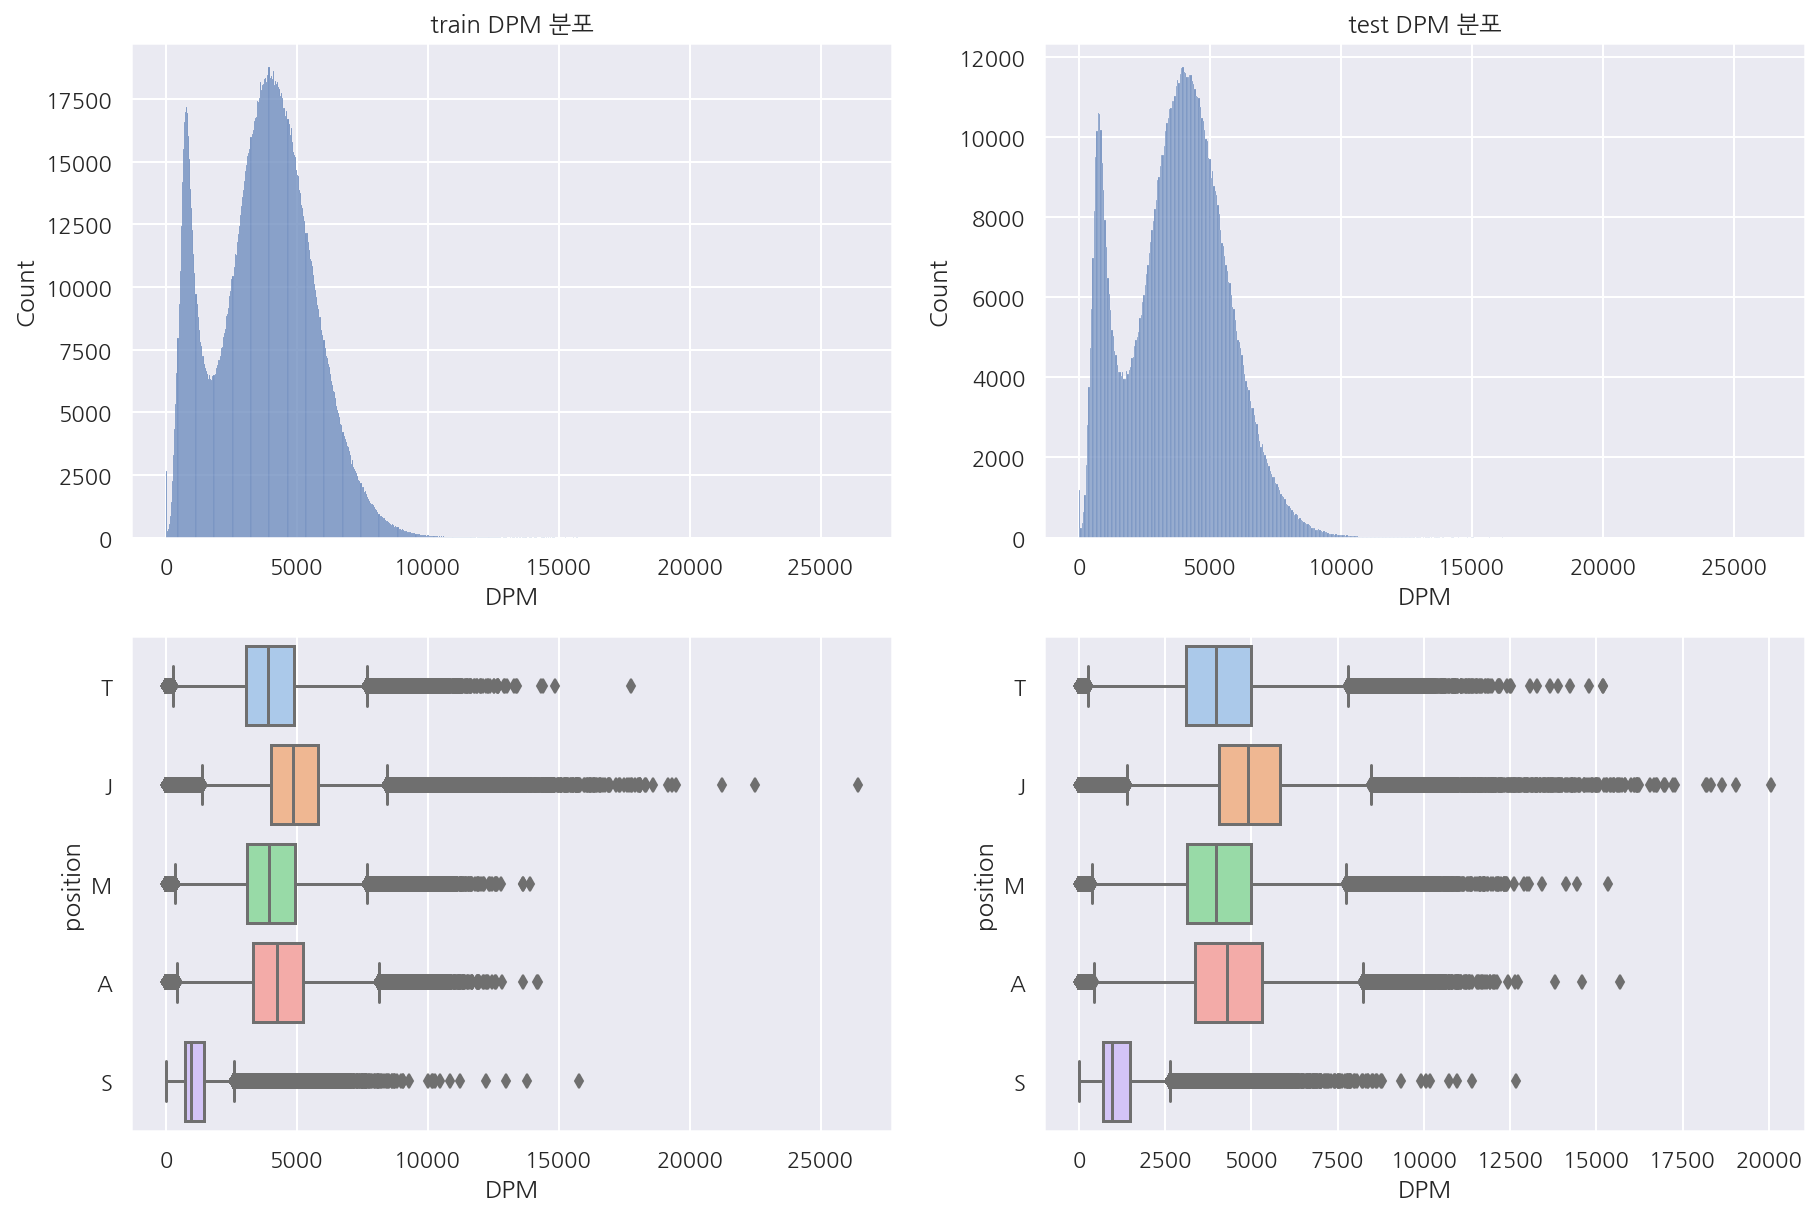

In [43]:
visualization("train", "test", "DPM")

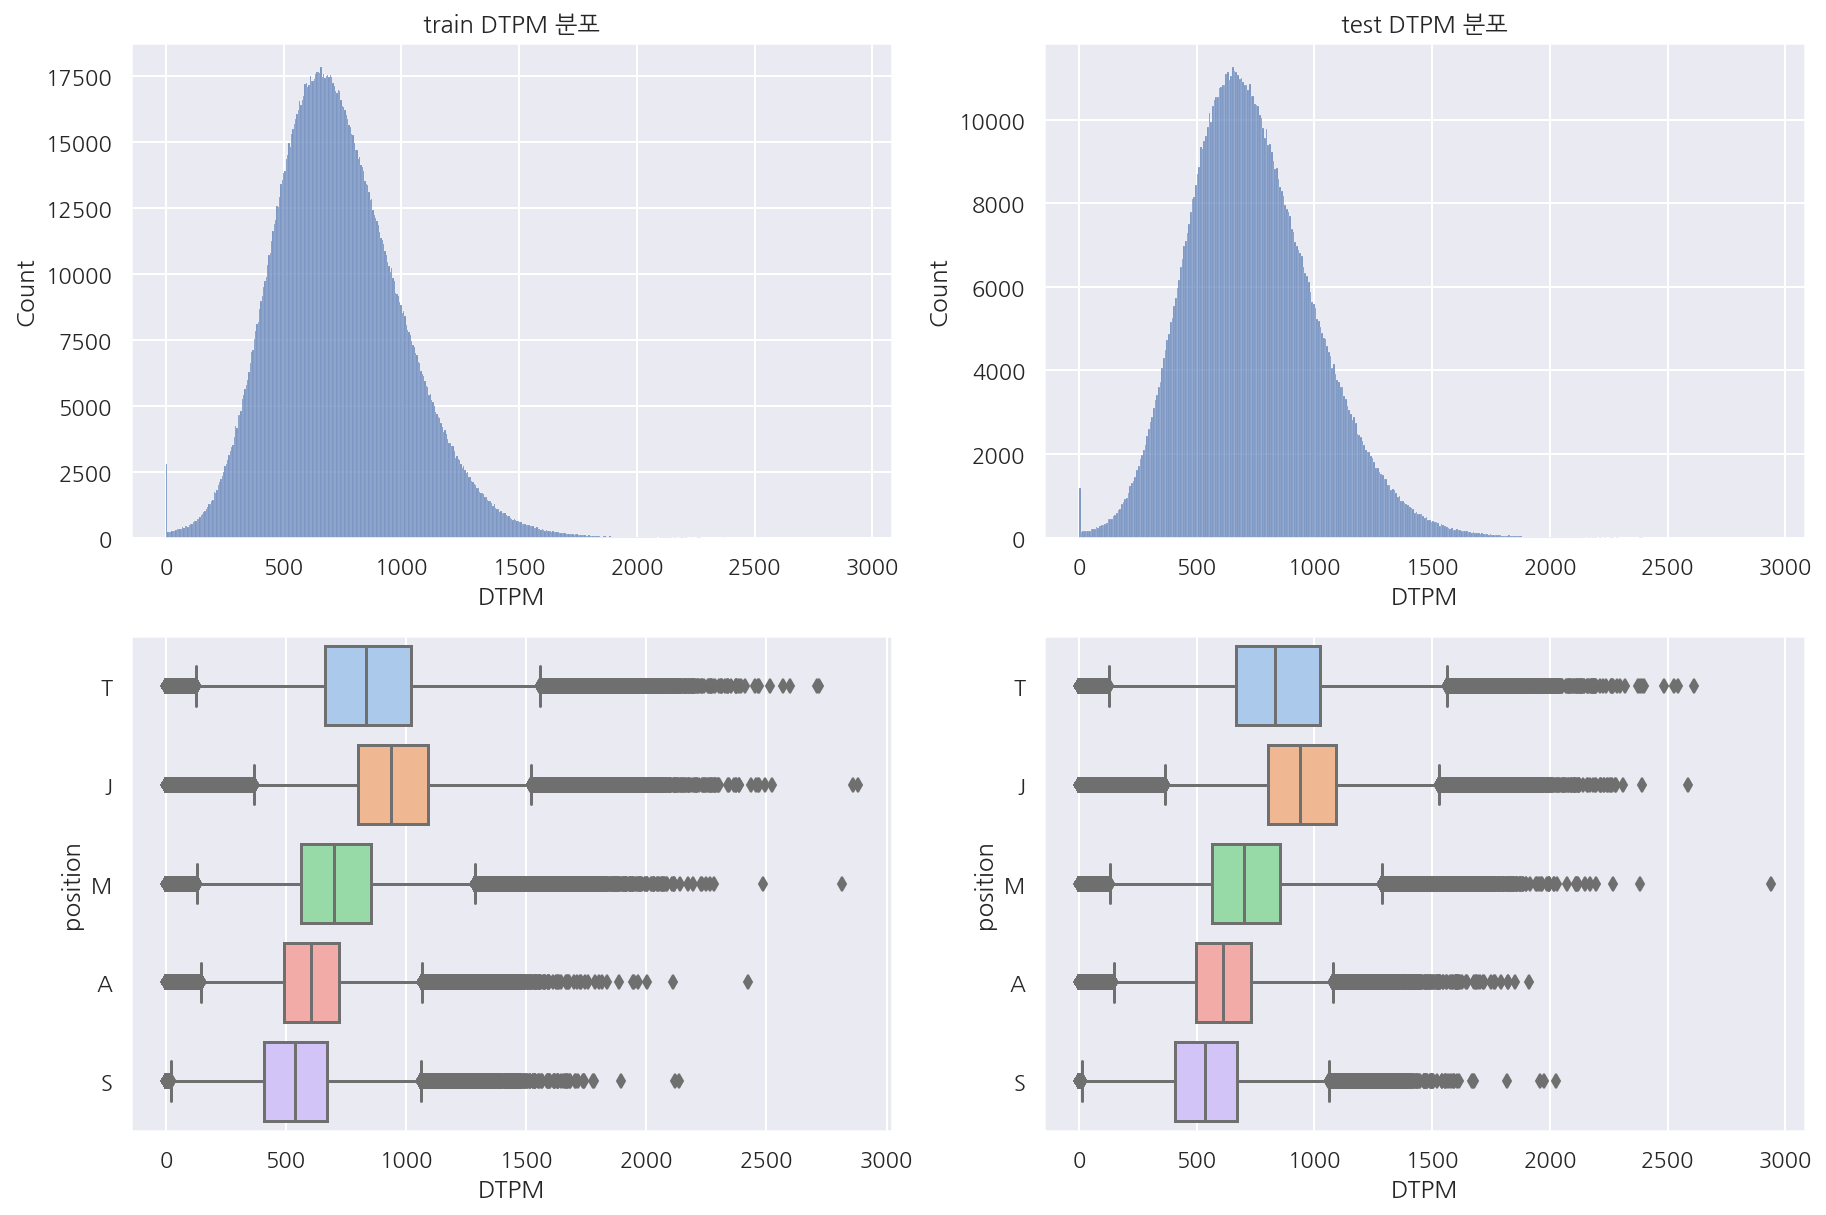

In [44]:
visualization("train", "test", "DTPM")

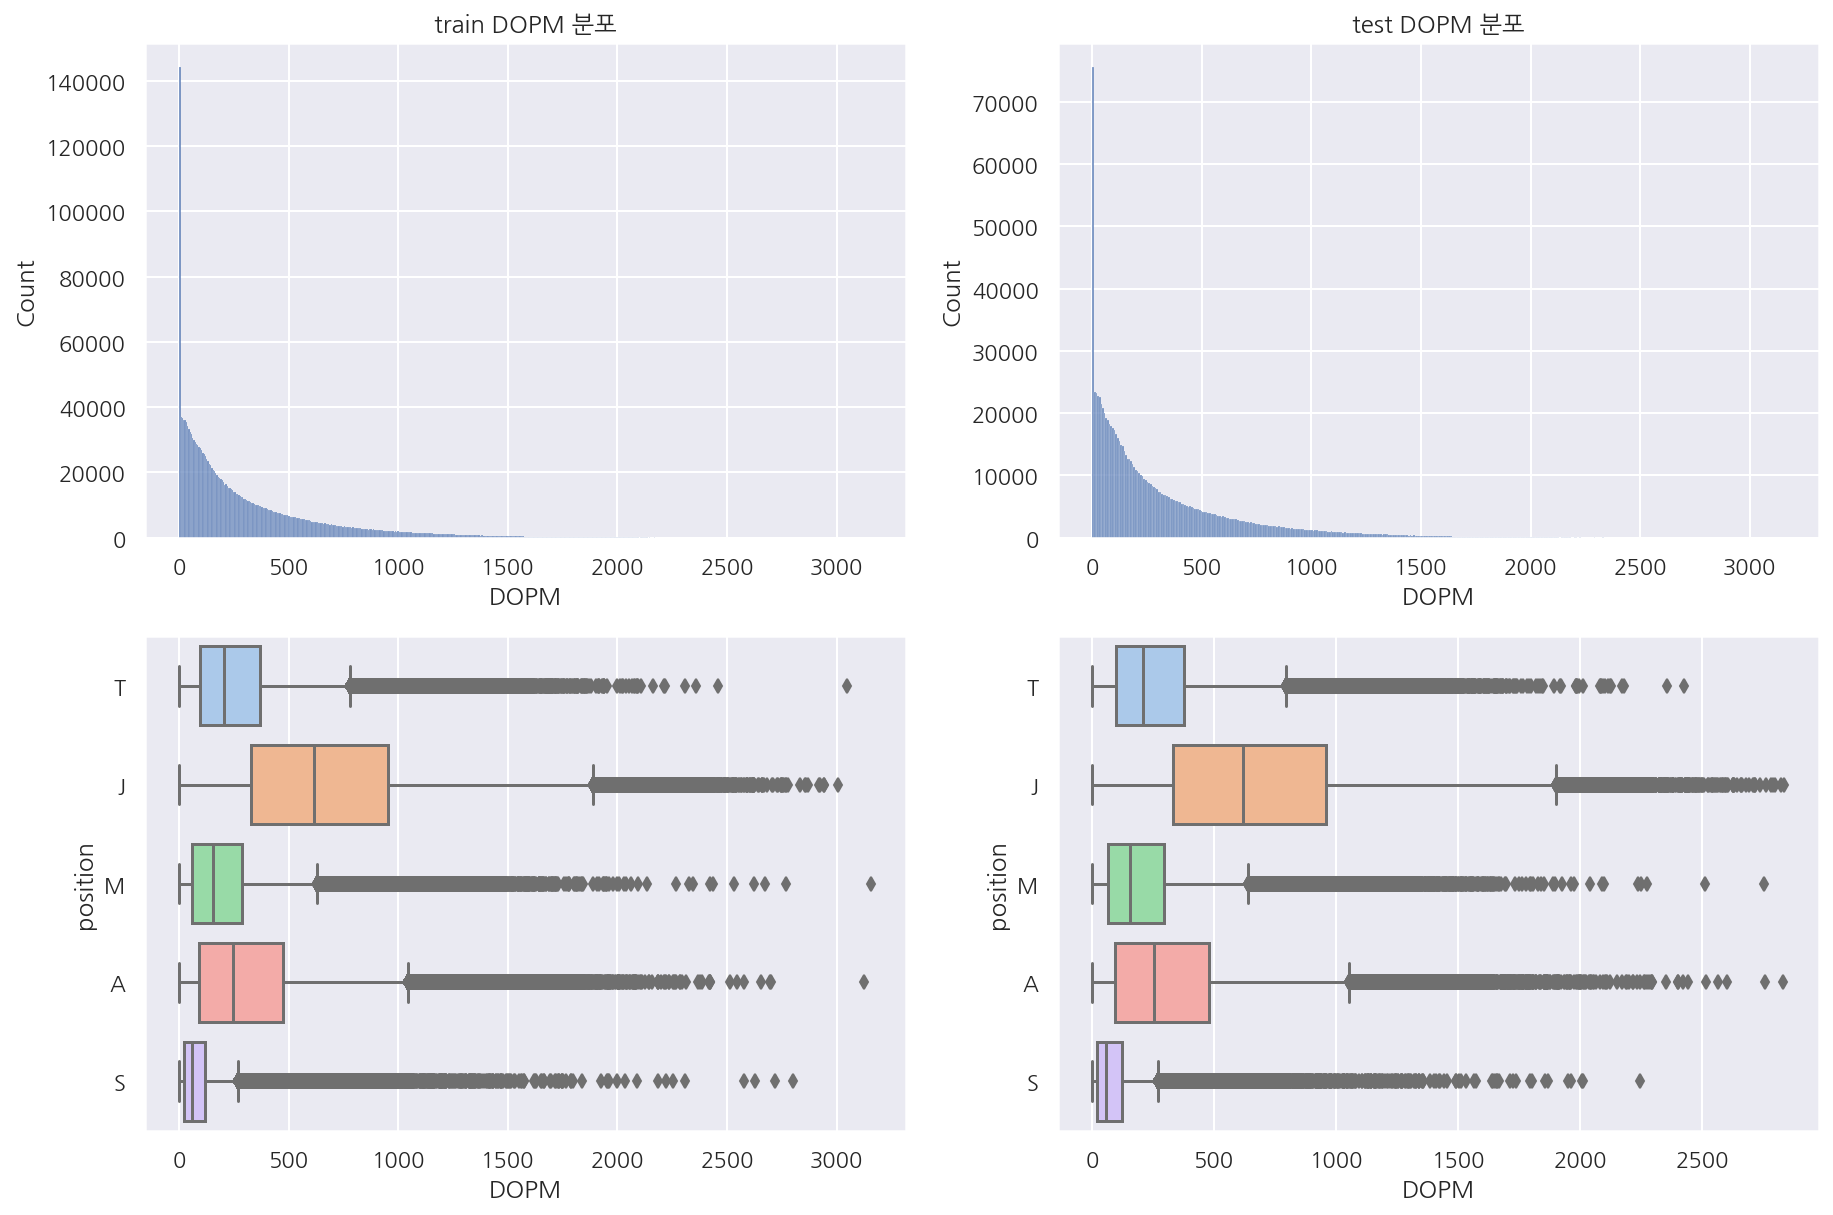

In [45]:
visualization("train", "test", "DOPM")

- 가한 데미지, 받은 데미지, 오브젝트에 가한 데미지 모두 train, test 분포는 비슷하다.

#### 1.4.7 아이템

In [46]:
# train, test 데이터 상의 아이템 key 중 item_df에 없는 것들 확인
item_col_lst = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
item_lst = []

# train item key
for col in item_col_lst:
    for v in train[col].unique():
        item_lst.append(v)

# test item key
for col in item_col_lst:
    for v in test[col].unique():
        item_lst.append(v)
        
item_lst_fin = sorted(list(set(item_lst)))

In [47]:
# item_df에는 없고 train, test에는 있는 아이템
item_df_fin = pd.DataFrame(item_lst_fin, columns=["key"])
temp = pd.merge(item_df_fin, item_df, how="left")
temp[temp["name"].isnull()].key.values

array([   0, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009,
       7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020,
       7021, 7022], dtype=int64)

- train, test에는 있는데 라이엇 API로 불러온 아이템 정보에는 없는 경우가 있다.


- 0은 아이템이 없다는 것이며 나머지 7000번대는 오른의 걸작 아이템들이다.


- 사실 아이템 정보에 왜 없는지 모르겠으나 이전 수업 때 본 경험이 있어 빨리 눈치 챘다.


- (아마 더 뜯어보면 오른의 걸작 정보가 있을 것 같은데 이전 수업 덕에 뒤 작업에서도 편하게 하긴 했다..)

In [48]:
# train, test 아이템 변환
df_lst = [train, test]
item_col_lst = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']

for df in df_lst:
    for col in item_col_lst:
        # 약간 신비한 신발 => 신발 치환
        df[col][df[col] == 2422] = 1001

        # 초시계 시리즈 => 초시계 치환
        df[col][df[col].isin([2419, 2421, 2423, 2424])] = 2420

        # 무라마나 => 마나무네 치환
        # 대천사의 포옹 => 대천사의 지팡이 치환
        df[col][df[col] == 3042] = 3004
        df[col][df[col] == 3040] = 3003

        # 오른의 걸작 치환
        df[col][df[col] == 7000] = 6693
        df[col][df[col] == 7001] = 6692
        df[col][df[col] == 7002] = 6691
        df[col][df[col] == 7003] = 6664
        df[col][df[col] == 7004] = 3068
        df[col][df[col] == 7005] = 6662
        df[col][df[col] == 7006] = 6671
        df[col][df[col] == 7007] = 6672
        df[col][df[col] == 7008] = 6673
        df[col][df[col] == 7009] = 4633
        df[col][df[col] == 7010] = 4636
        df[col][df[col] == 7011] = 3152
        df[col][df[col] == 7012] = 6653
        df[col][df[col] == 7013] = 6655
        df[col][df[col] == 7014] = 6656
        df[col][df[col] == 7015] = 6630
        df[col][df[col] == 7016] = 6631
        df[col][df[col] == 7017] = 6632
        df[col][df[col] == 7018] = 3078
        df[col][df[col] == 7019] = 3190
        df[col][df[col] == 7020] = 2065
        df[col][df[col] == 7021] = 6617
        df[col][df[col] == 7022] = 4005

        # 서폿 아이템 (초기 아이템으로 변환)
        df[col][df[col].isin([3851, 3853])] = 3850
        df[col][df[col].isin([3855, 3857])] = 3854
        df[col][df[col].isin([3859, 3860])] = 3858
        df[col][df[col].isin([3863, 3864])] = 3862

- 동일 계열 아이템들은 같은템으로 변환하였다.


- 신비한 장화, 무라마나, 대천사의 포옹, 오른의 걸작, 서폿 아이템 등을 변환시켜주었다.


- 와드 쪽에서 피들스틱 허수아비, 전령의 눈은 별도 처리 하지 않았다.

#### 1.4.8 챔피언

챔피언은 따로 시각화는 하지 않았다.

#### 1.4.9 게임시간

In [49]:
# 게임 시간 5분 단위로 (ex 15분이상 20분 미만)
length = ((train["gameLength"]/60) //5*5)

# 게임 시간 상한 설정 (60분 넘으면 변경)
length[length > 60] = 60

len1 = (length).astype(int).astype(str).str.zfill(2)
len2 = (length + 5).astype(int).astype(str).str.zfill(2)

train["length_dummy"] = len1 + "_" + len2 + "min"

# test 동일 과정
length = ((test["gameLength"]/60) //5*5)

length[length > 60] = 60

len1 = (length).astype(int).astype(str).str.zfill(2)
len2 = (length + 5).astype(int).astype(str).str.zfill(2)

test["length_dummy"] = len1 + "_" + len2 + "min"

In [50]:
train["length_dummy"].unique()

array(['25_30min', '20_25min', '30_35min', '15_20min', '35_40min',
       '10_15min', '40_45min', '00_05min', '45_50min', '50_55min',
       '05_10min', '55_60min', '60_65min'], dtype=object)

In [51]:
test["length_dummy"].unique()

array(['25_30min', '10_15min', '15_20min', '30_35min', '40_45min',
       '35_40min', '20_25min', '00_05min', '45_50min', '50_55min',
       '05_10min', '60_65min', '55_60min'], dtype=object)

In [52]:
train["length_dummy"].value_counts().sort_index()

00_05min     19630
05_10min       110
10_15min     25390
15_20min    223320
20_25min    497650
25_30min    547310
30_35min    420430
35_40min    189320
40_45min     59810
45_50min     14090
50_55min      2500
55_60min       380
60_65min        60
Name: length_dummy, dtype: int64

In [53]:
test["length_dummy"].value_counts().sort_index()

00_05min      7880
05_10min        70
10_15min     12390
15_20min    110990
20_25min    246880
25_30min    270900
30_35min    210610
35_40min     99080
40_45min     32230
45_50min      7320
50_55min      1310
55_60min       230
60_65min       110
Name: length_dummy, dtype: int64

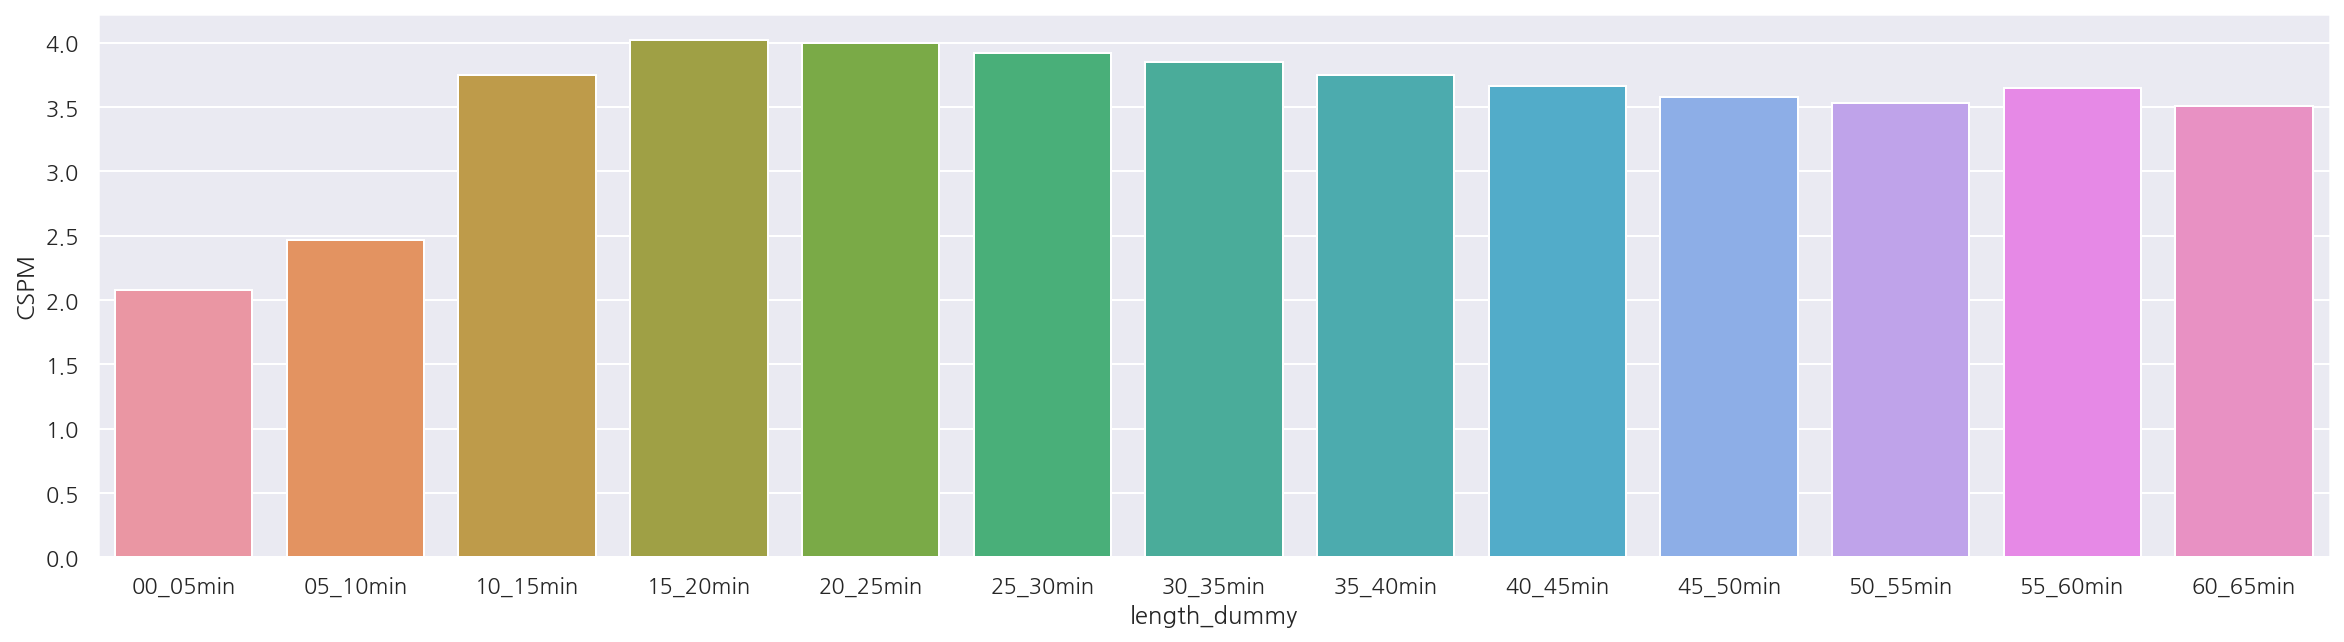

In [54]:
# 게임 시간 구간별 지표
fig = plt.figure(figsize = (20,5))

p1 = sns.barplot(data = train,
                 x = "length_dummy", y = "CSPM",
                 order = np.sort(train["length_dummy"].unique()),
                 ci = None)

p1.set_xticklabels(labels = p1.get_xticklabels(), 
                   rotation = 0)

plt.show()

- 0_5분, 5_10분은 CSPM이 상대적으로 낮게 나타나지만 빈도 자체가 많지는 않다.

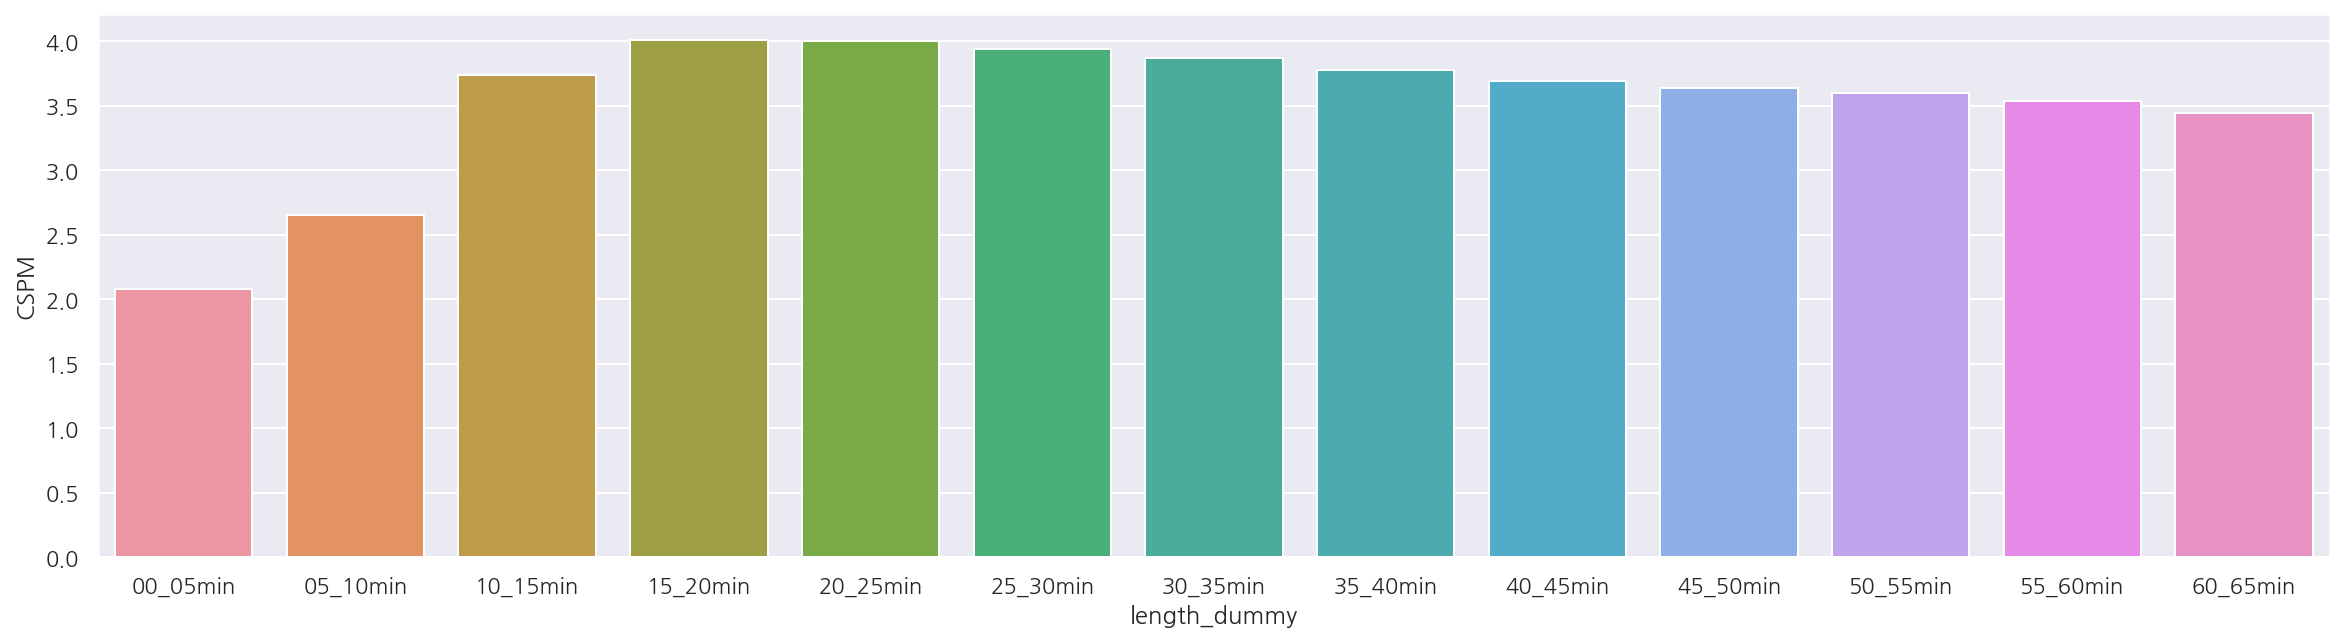

In [55]:
# 게임 시간 구간별 지표
fig = plt.figure(figsize = (20,5))

p1 = sns.barplot(data = test,
                 x = "length_dummy", y = "CSPM",
                 order = np.sort(train["length_dummy"].unique()),
                 ci = None)

p1.set_xticklabels(labels = p1.get_xticklabels(), 
                   rotation = 0)

plt.show()

- test도 비슷하게 나타난다.

### 1.5 전처리

앞서 포지션 분류에 도움이 될 변수들을 확인 하였을 때 CS, 와드, 스펠에서 확실히 구분이 좀 되었다.

그리고 챔피언에 따라 아이템, 스펠이 달라질 것이므로 역시 중요하게 생각된다.

아이템 역시 서폿 아이템, 정글 아이템 등도 분류에 도움이 될 것 같다.

(정글 아이템은 11.18 기준 강타 5번 사용하면 사라지는 엉걸불 칼, 빗발칼날이라 게임 후반엔 없을 것)

게임시간의 경우 다시하기나 조기항복 등의 경우도 우선 포지션 분류를 하고자 제외하진 않으려 한다.

위에선 확인하진 않았지만 티어에 따라 CS, 와드 등 지표 값이 다를 것이라 생각하여 포함하려 한다.

In [56]:
# 영어로 불러오기
champion_df, spell_df, item_df = load_riot_info(lan="en_US")

In [57]:
# 챔피언, 스펠, 아이템 이름 붙이기
train = merge_name(train)
test = merge_name(test)

In [58]:
# item 결측값 0으로 대체 (원-핫 인코딩 후 0 컬럼 삭제)
item_col = ['item00', 'item01', 'item02', 'item03', 'item04', 'item05', 'item06']

for col in item_col:
    train[col].fillna(0, inplace = True)
    test[col].fillna(0, inplace = True)

- 우선 챔피언, 스펠, 아이템 정보 등을 각 데이터셋에 조인하였다.

#### 1.5.1 원핫 인코딩

티어, 챔피언, 스펠, 아이템 등은 원핫 인코딩으로 작업하였다.

In [59]:
# 티어
tier_oh_train = pd.get_dummies(train["tier"])
tier_oh_test = pd.get_dummies(test["tier"])

In [60]:
# 챔피언
champ_oh_train = pd.get_dummies(train["champion"])
champ_oh_test = pd.get_dummies(test["champion"])

In [61]:
# 스펠
spell_oh_train = pd.get_dummies(train["spell01"]) + pd.get_dummies(train["spell02"])
spell_oh_test = pd.get_dummies(test["spell01"]) + pd.get_dummies(test["spell02"])

- 티어, 챔피언, 스펠 등 현재 train, test 모두 동일 범주이므로 같은 기준 일치된다.


- 스펠은 데이터가 작다면 위와 같은 방식은 좋지 않다(챔피언 역시 마찬가지).

In [62]:
# 아이템
item_col = ['item00', 'item01', 'item02', 'item03', 'item04', 'item05', 'item06']
temp = pd.concat([train[col] for col in item_col], axis=0)

temp2 = pd.get_dummies(temp)

# 기존 데이터 행수 
interval = int(temp2.shape[0] / len(item_col))

item_oh_train = temp2.iloc[0:interval,:]

for i in range(0, temp2.shape[0], interval):
    if i != 0:
        item_oh_train = item_oh_train + temp2.iloc[i:i + interval,:]

In [63]:
# 아이템
item_col = ['item00', 'item01', 'item02', 'item03', 'item04', 'item05', 'item06']
temp = pd.concat([test[col] for col in item_col], axis=0)

temp2 = pd.get_dummies(temp)

# 기존 데이터 행수 
interval = int(temp2.shape[0] / len(item_col))

item_oh_test = temp2.iloc[0:interval,:]

for i in range(0, temp2.shape[0], interval):
    if i != 0:
        item_oh_test = item_oh_test + temp2.iloc[i:i + interval,:]

In [64]:
# train, test 컬럼 동일
set(item_oh_train.columns) == set(item_oh_test.columns)

True

- 아이템 컬럼이 여러 개이기에 원핫 인코딩이 개인적으로 조금 더 까다로웠다.


- 우선 위 스펠처럼 아이템 컬럼들이 모두 동일한 숫자의 아이템이 있지 않다.


- 그래서 각 컬럼 값을 세로로 합치고 원핫 인코딩 후 다시 기존 row수에 맞게 데이터를 잘라 가로로 더해주었다.

In [65]:
# 0 컬럼(비어있는 아이템 칸) 제거
item_oh_train.drop(columns=0, axis=1, inplace=True)
item_oh_test.drop(columns=0, axis=1, inplace=True)

In [66]:
# 결측값 0으로 대체 / 중복값 1로 수정(루비수정 6개 -> 그냥 루비수정 1)
item_oh_train_fin = item_oh_train / item_oh_train
item_oh_train_fin.fillna(0, inplace=True)

item_oh_test_fin = item_oh_test / item_oh_test
item_oh_test_fin.fillna(0, inplace=True)

- 아이템칸이 비어있는 경우는 제거하였다.


- 그리고 아이템을 중복해서 가지고 있는 경우는 원핫 인코딩의 의미대로 1로 만들어 주었다.

In [67]:
# 원핫 인코딩 결과 합치기
oh_train = pd.concat([tier_oh_train, champ_oh_train ,spell_oh_train, item_oh_train_fin], axis=1)
oh_test = pd.concat([tier_oh_test, champ_oh_test ,spell_oh_test, item_oh_test_fin], axis=1)

- 티어, 챔피언, 스펠, 아이템 원핫 인코딩 결과를 합쳐두었다.


- 주의할 점은 인덱스 순서가 변하지 않았는지 잘 확인해야한다.


- (물론 위 코드에서는 그런 경우가 없지만 생각을 하고 봐야 한다.)

#### 1.5.2 임시 최종 데이터

In [68]:
temp1 = train[['DPM', 'CSPM', 'WPPM', 'JCSPM']]
temp2 = test[['DPM', 'CSPM', 'WPPM', 'JCSPM']]

train_fin = pd.concat([temp1, oh_train], axis=1)
test_fin = pd.concat([temp2, oh_test], axis=1)

- 최종적으로 컬럼은 분당 데미지, CS, 정글CS, 와드 설치 수를 추가해두었다.


- 다른 변수도 많지만 앞서 확인한 시각화 자료를 통해 더 중요해 보이는 변수들만 넣어두었다.

In [69]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder.fit(train["position"])
Y_train = encoder.transform(train["position"])
Y_test = encoder.transform(test["position"])

In [70]:
# 피처 array 형태
X_train = train_fin.values.astype(float)
X_test = test_fin.values.astype(float)

# target 원핫 인코딩
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

### 1.6 모델 실행

In [71]:
# 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

# 모델 설정
model = Sequential()
model.add(Dense(20, input_dim=356, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(5, activation="softmax"))

# 모델 컴파일
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

# 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor="loss", patience=10)

# 모델 실행
model.fit(X_train, Y_train, epochs=100, batch_size=1000,
          callbacks = [early_stopping_callback])

# 결과 출력
print("-"*100)
print(f"Accuracy: {model.evaluate(X_test, Y_test, verbose=0)[1]: .4f}")

Train on 2000000 samples
Epoch 1/100
2000000/2000000 [==============================] - 15s 7us/sample - loss: 1.4176 - accuracy: 0.8460
Epoch 2/100
2000000/2000000 [==============================] - 10s 5us/sample - loss: 0.2695 - accuracy: 0.9153
Epoch 3/100
2000000/2000000 [==============================] - 10s 5us/sample - loss: 0.2423 - accuracy: 0.9233
Epoch 4/100
2000000/2000000 [==============================] - 11s 6us/sample - loss: 0.2333 - accuracy: 0.9256
Epoch 5/100
2000000/2000000 [==============================] - 10s 5us/sample - loss: 0.2284 - accuracy: 0.9273
Epoch 6/100
2000000/2000000 [==============================] - 10s 5us/sample - loss: 0.2194 - accuracy: 0.9291
Epoch 7/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.2178 - accuracy: 0.9295
Epoch 8/100
2000000/2000000 [==============================] - 10s 5us/sample - loss: 0.2173 - accuracy: 0.9294
Epoch 9/100
2000000/2000000 [==============================] - 9s 5us/sample - l

2000000/2000000 [==============================] - 9s 4us/sample - loss: 0.1858 - accuracy: 0.9363
Epoch 74/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.1858 - accuracy: 0.9365
Epoch 75/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.1859 - accuracy: 0.9363
Epoch 76/100
2000000/2000000 [==============================] - 9s 4us/sample - loss: 0.1858 - accuracy: 0.9363
Epoch 77/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.1856 - accuracy: 0.9363
Epoch 78/100
2000000/2000000 [==============================] - 9s 4us/sample - loss: 0.1859 - accuracy: 0.9363
Epoch 79/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.1854 - accuracy: 0.9365
Epoch 80/100
2000000/2000000 [==============================] - 9s 5us/sample - loss: 0.1854 - accuracy: 0.9365
Epoch 81/100
2000000/2000000 [==============================] - 9s 4us/sample - loss: 0.1853 - accuracy: 0.9365
Epoch

- 노드, 레이어, 에포크, 배치 사이즈 수 등은 컴퓨터 성능과 구글링 정보에 따라 조율하였다.


- 작업하면서 정확도가 20%대로 local optimum으로 가기도 했고 잘나오기도 했다.


- 여러 결과에서 93%대가 가장 높았으며 test역시 비슷한 정확도를 보인다.


- 아무래도 train, test의 여러 변수 분포들이 거의 흡사하였기 때문인 것 같다.


- 분포가 흡사한 점 때문에 모델 학습에서도 굳이 validaition set을 설정하지도 않았고 train의 성능부터 높이려 했다.

### 1.7 추가 작업

In [72]:
# 예측 결과 분류 값
y_pred = model.predict_classes(X_test)
y_pred_df = pd.DataFrame(encoder.inverse_transform(y_pred), columns=["position_pred"])

In [73]:
# 예측 확률 값
y_pred_prob = model.predict(X_test)
y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=["A","J","M","S","T"])
y_pred_prob_df = y_pred_prob_df[["T","J","M","A","S"]]

In [74]:
# 예측 값 추가
test_pred = pd.concat([test, y_pred_df, y_pred_prob_df], axis=1)

# 예측 값 카테고리화
cat_size_order = CategoricalDtype(['T', 'J', 'M', 'A', 'S'], ordered=True)
test_pred['position_pred'] = test_pred['position_pred'].astype(cat_size_order)

In [75]:
test_pred["position_pred"].value_counts()

M    207883
J    200165
S    198485
T    197308
A    196159
Name: position_pred, dtype: int64

- 각 게임은 2개의 팀, 그리고 팀당 5개의 포지션이 나타나야한다.


- 그러나 모델에서 예측은 row단위로 진행되기에 한 팀에 중복 포지션이 나타날 수 밖에 없다.


- 포지션이 원래 값과 다른 경우는 있어도 된다고 생각하지만 포지션이 다 분류가 안된건 작업이 필요하다.

In [76]:
test_pred.groupby(["position", "position_pred"]).size().unstack(["position_pred"])

position_pred,T,J,M,A,S
position,,,,,
T,172412,209,25442,1501,436
J,184,199068,343,56,349
M,21466,252,174791,2629,862
A,2258,107,5762,191547,326
S,988,529,1545,426,196512


- 참고로 기존 값이랑 결과가 어떻게 다른지인데 확실히 탑, 미드가 덜 구분된게 보인다.


- 다만 기존 값 역시 OP.GG의 예측값이니 우선 포지션 전체 분류부터 신경쓰자.

In [77]:
# 다르게 예측한 것 중에서도 한 게임의 한 팀에서 포지션이 5개가 아닌 경우
mismatch = test_pred.groupby(["gameId", "teamId"]).nunique()[["position_pred"]].reset_index()
mismatch = mismatch[mismatch["position_pred"] != 5]

In [78]:
mismatch.position_pred.value_counts()

4    41914
3     1307
2       30
1        1
Name: position_pred, dtype: int64

- 포지션 1개가 중복된 경우가 41,914건으로 가장 많았다.


- 경우의 수가 다양하므로 코드를 융통성 있게 잘 짜야할 필요가 있다.

In [79]:
dup1 = mismatch[mismatch["position_pred"] == 4]["gameId"].values
dup2 = mismatch[mismatch["position_pred"] == 3]["gameId"].values
dup3 = mismatch[mismatch["position_pred"] == 2]["gameId"].values
dup4 = mismatch[mismatch["position_pred"] == 1]["gameId"].values

- 10만 게임 x 블루,레드 = 20만개의 팀 중 포지션이 5개가 안나온 경우가 대략 4만 3천 팀

In [80]:
while True:
    # 다르게 예측한 것 중에서도 한 게임의 한 팀에서 포지션이 5개가 아닌 경우
    mismatch = test_pred.groupby(["gameId", "teamId"]).nunique()[["position_pred"]].reset_index()
    mismatch = mismatch[mismatch["position_pred"] != 5].drop("position_pred", axis=1)
    
    print(f"남은 횟수: {mismatch.shape[0]}")
    
    # 모든 게임id, 팀id별 포지션 개수가 5개가 되면 stop
    if mismatch.shape[0] == 0:
        break
    
    i = 0
    
    for game, team in mismatch.values:
        # 중복 포지션 리스트
        sample_data = test_pred[(test_pred["gameId"]==game) & (test_pred["teamId"]==team)]
        dup_pos = sample_data["position_pred"].value_counts()
        dup_pos_lst = list(dup_pos[dup_pos>1].index)

        # 남은 포지션 (중복 포지션 및 유니크한 포지션 제외)
        col = list(dup_pos[dup_pos == 0].index)

        for pos in dup_pos_lst:
            # 해당 중복 포지션의 모든 인덱스
            total_idx = sample_data[sample_data["position_pred"] == pos].index
            
            # 중복 포지션 중 해당 포지션 열 확률이 가장 높은 인덱스
            max_idx = sample_data[sample_data["position_pred"] == pos][pos].idxmax(axis=0)
            
            # 중복 포지션 중 해당 포지션 열 확률이 가장 높은 경우 제외하고 남은 포지션 중 행 확률이 가장 높은 포지션
            for idx in list(set(total_idx) - {max_idx}):
                new_position = sample_data.loc[idx, col].astype(float).idxmax()
                test_pred.loc[idx,"position_pred"] = new_position

        if i % 1000 == 0:
            print(f"{i}번째 완료")
        i += 1

남은 횟수: 43252
0번째 완료
1000번째 완료
2000번째 완료
3000번째 완료
4000번째 완료
5000번째 완료
6000번째 완료
7000번째 완료
8000번째 완료
9000번째 완료
10000번째 완료
11000번째 완료
12000번째 완료
13000번째 완료
14000번째 완료
15000번째 완료
16000번째 완료
17000번째 완료
18000번째 완료
19000번째 완료
20000번째 완료
21000번째 완료
22000번째 완료
23000번째 완료
24000번째 완료
25000번째 완료
26000번째 완료
27000번째 완료
28000번째 완료
29000번째 완료
30000번째 완료
31000번째 완료
32000번째 완료
33000번째 완료
34000번째 완료
35000번째 완료
36000번째 완료
37000번째 완료
38000번째 완료
39000번째 완료
40000번째 완료
41000번째 완료
42000번째 완료
43000번째 완료
남은 횟수: 733
0번째 완료
남은 횟수: 3
0번째 완료
남은 횟수: 0


- 한 팀에서 중복 포지션이 나타난 경우 해당 포지션의 예측 확률이 가장 높은 플레이어에게 포지션을 부여한다. (열 단위)


- 나머지 플레이어는 남아있는 포지션 중 가장 높은 확률인 포지션으로 분류한다. (행 단위)


- 이를 팀에서 중복 포지션이 없을 때까지 반복하였다.


- 중복 포지션 경우의 수가 다양하기에 조금 무식한? 방법으로 코드를 짰다.

### 1.8 차이점 확인

In [81]:
# 다르게 예측한 경우의 gameId
mismatch_gameid = test_pred[test_pred["position"] != test_pred["position_pred"]]["gameId"].unique()

In [82]:
mismatch_gameid.shape

(17898,)

In [83]:
mismatch_gameid

array([5443212341, 5443212342, 5443212349, ..., 5443735957, 5443735959,
       5443736015], dtype=int64)

In [84]:
check_col = ["gameId", "teamId", "champion", "position", "position_pred", 
             "T", "J", "M", "A", "S",
             "spell01", "spell02", "minionsKilled", "gameLength"]

In [86]:
test_pred[(test_pred["champion"]=="Senna")].groupby(["position"]).size()

position
T     182
J       4
M      89
A     784
S    6496
dtype: int64

In [87]:
test_pred[(test_pred["champion"]=="Senna")].groupby(["position_pred"]).size()

position_pred
T     165
J       3
M      79
A     758
S    6550
dtype: int64

In [88]:
test_pred[(test_pred["champion"]=="Senna") & (test_pred["position"] != test_pred["position_pred"])]

,gameId,createDate,teamId,summonerId,participantId,championId,result,spell1,spell2,item0,...,item03,item04,item05,item06,position_pred,T,J,M,A,S
13270,5443219493,2021-09-10 00:13:50,200,2463313,7,235,LOSE,12,4,1055,...,Noonquiver,Boots of Swiftness,0,Stealth Ward,T,0.645054,0.007501,0.165086,0.087296,0.095064
24272,5443225285,2021-09-09 23:53:12,100,8776322,1,235,LOSE,4,6,6672,...,Dagger,0,0,Stealth Ward,T,0.475532,0.002259,0.255152,0.199234,0.067823
57806,5443243581,2021-09-09 23:32:43,100,82739550,4,235,WIN,4,21,2010,...,Sheen,Hearthbound Axe,0,Oracle Lens,S,0.100548,0.009774,0.096448,0.020220,0.773010
72627,5443251499,2021-09-09 23:35:56,100,78580948,2,235,WIN,12,4,6632,...,Zeal,Dagger,0,Stealth Ward,S,0.940839,0.000068,0.047021,0.010477,0.001595
73602,5443252043,2021-09-09 23:52:48,100,16600515,3,235,LOSE,21,4,3071,...,Rapid Firecannon,Guinsoo's Rageblade,Mortal Reminder,Farsight Alteration,S,0.298470,0.001291,0.176387,0.214312,0.309540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973978,5443724491,2021-09-10 14:25:53,100,86208135,4,235,LOSE,3,4,1006,...,Rejuvenation Bead,Rejuvenation Bead,Rejuvenation Bead,Oracle Lens,S,0.004213,0.003363,0.003644,0.004185,0.984595
977263,5443725924,2021-09-10 14:58:19,200,17970549,6,235,LOSE,21,4,6672,...,Caulfield's Warhammer,Doran's Blade,Boots of Swiftness,Farsight Alteration,A,0.245785,0.001083,0.192459,0.363467,0.197207
990130,5443731650,2021-09-10 13:51:14,200,4802635,7,235,LOSE,4,3,2031,...,Phage,Ruby Crystal,0,Oracle Lens,S,0.011027,0.001196,0.009553,0.004350,0.973874
991014,5443732096,2021-09-10 13:58:23,100,34430595,1,235,LOSE,14,4,3862,...,0,0,0,Oracle Lens,S,0.038567,0.000264,0.027978,0.020312,0.912880


- 세나는 대표적으로 원딜, 서폿 분류가 애매한 챔피언 중 하나이다.


- 세나가 있으면서 포지션 예측 결과가 다른 경우의 gameid를 확인하였다.

In [102]:
test_pred[(test_pred["champion"]=="Senna") & (test_pred["position"] == "J")][check_col]

,gameId,teamId,champion,position,position_pred,T,J,M,A,S,spell01,spell02,minionsKilled,gameLength
29434,5443228050,200,Senna,J,J,0.000049,0.983919,0.000037,0.000136,0.015859,Smite,Flash,36,1870
722380,5443606899,200,Senna,J,J,0.000036,0.999258,0.000016,0.000065,0.000625,Smite,Flash,62,2052
743870,5443617149,100,Senna,J,S,0.069116,0.127701,0.206962,0.014350,0.581871,Cleanse,Flash,0,195
846101,5443665504,100,Senna,J,S,0.014600,0.001339,0.007780,0.005712,0.970569,Barrier,Flash,7,619


- 위 결과는 세나가 정글로 간 게임이 있어서(이상값) 확인한 정보이다.


- 기존 값은 모두 정글로 예측하였지만 이번에 만든 모델은 두 개는 서폿으로 분류하였다.


- 스펠을 보면 강타를 든 2건만 정글로 분류하였고 정화, 방어막은 서폿으로 분류하였다.


- 물론 인게임을 안봤지만 좀 더 정확해보인다.

In [90]:
test_pred[test_pred["gameId"]==5443243581][check_col].sort_values(by=["teamId","position"])

,gameId,teamId,champion,position,position_pred,T,J,M,A,S,spell01,spell02,minionsKilled,gameLength
57805,5443243581,100,Yasuo,T,M,0.263105,0.002282,0.592269,0.081899,0.060445,Ignite,Flash,45,472
57800,5443243581,100,Lee Sin,J,J,0.045285,0.863407,0.040711,0.033260,0.017336,Flash,Smite,16,472
57806,5443243581,100,Senna,M,S,0.100548,0.009774,0.096448,0.020220,0.773010,Flash,Barrier,3,472
57804,5443243581,100,Ashe,A,A,0.039292,0.002088,0.032077,0.919321,0.007222,Cleanse,Flash,33,472
57807,5443243581,100,Darius,S,T,0.844689,0.001250,0.067365,0.017489,0.069207,Ghost,Flash,25,472
57802,5443243581,200,Fiora,T,T,0.831150,0.011136,0.077899,0.013483,0.066332,Teleport,Flash,10,472
57808,5443243581,200,Syndra,J,M,0.058241,0.020639,0.674983,0.027789,0.218349,Flash,Teleport,15,472
57801,5443243581,200,Ekko,M,J,0.039600,0.718131,0.154000,0.007273,0.080996,Flash,Smite,3,472
57803,5443243581,200,Vayne,A,A,0.046305,0.017203,0.030690,0.877947,0.027854,Cleanse,Flash,38,472
57809,5443243581,200,Thresh,S,S,0.022308,0.009564,0.064239,0.001262,0.902626,Ignite,Flash,14,472


- 위 경우 블루팀, 레드팀 모두 포지션 예측 값이 많이 다르다. 


- 다만 스펠이나 챔피언 목록을 보면 새로 예측한 값이 좀 더 정확해보인다.

In [91]:
test_pred[test_pred["gameId"]==5443724491][check_col].sort_values(by=["teamId","position"])

,gameId,teamId,champion,position,position_pred,T,J,M,A,S,spell01,spell02,minionsKilled,gameLength
973978,5443724491,100,Senna,T,S,0.004213,0.003363,0.003644,4.185159e-03,0.984595,Exhaust,Flash,2,824
973975,5443724491,100,Volibear,J,J,0.000078,0.999533,0.000104,6.605670e-06,0.000278,Smite,Flash,4,824
973976,5443724491,100,Jax,M,T,0.897949,0.000177,0.085457,9.550376e-03,0.006866,Teleport,Flash,78,824
973972,5443724491,100,Xayah,A,A,0.017828,0.000131,0.019802,9.589857e-01,0.003254,Flash,Heal,74,824
973977,5443724491,100,Talon,S,M,0.192979,0.002681,0.750141,3.825368e-02,0.015945,Ignite,Flash,74,824
973973,5443724491,200,Sett,T,M,0.895342,0.000023,0.098913,5.252037e-03,0.000470,Teleport,Flash,117,824
973971,5443724491,200,Graves,J,J,0.000001,0.999982,0.000009,1.931255e-08,0.000007,Smite,Flash,7,824
973970,5443724491,200,Gangplank,M,T,0.935472,0.000044,0.059929,3.270592e-03,0.001285,Flash,Teleport,84,824
973979,5443724491,200,Ezreal,A,A,0.007480,0.000058,0.015224,9.753906e-01,0.001847,Heal,Flash,102,824
973974,5443724491,200,Blitzcrank,S,S,0.001085,0.000753,0.001355,4.264727e-04,0.996380,Ignite,Flash,18,824


- 위 경우도 앞서 확인한 것과 마찬가지로 새로 예측한 값이 좀 더 정확해 보인다.

In [92]:
accuracy_score(test_pred["position"], test_pred["position_pred"])

0.958809

- 정확도 95.88%로 기존보다 상승하였다.

### 1.9 EOD

이번에는 프로젝트나 강의를 받으면서 느낀 점을 쓰면 너무 길어질 것 같아 이번 결과에 대해서 간단히만 정리하려 한다.

- 우선 기존 분류 예측값과의 정확도가 높게 나타났다.


- 물론 내가 잘못 분류하였거나 OP.GG가 잘못 분류하였거나 경우의 수가 많다. 


- 하지만 95%대의 정확도가 나타났다는 점에서 일반적인 게임은 동일하게 분류를 한 것 같다.


- 그리고 일부 확인한 것이지만 조금 더 포지션 분류가 잘 된 경우가 보인다.


- 사실 실제 적용한다면 챔피언, 아이템 등에서 원핫 인코딩을 했기에 보완하거나 그때 그때 수정할 필요가 있긴 하다.